In [1]:
%pwd

'c:\\Users\\K Suryanarayana\\Desktop\\EE23D015'

## Part 1
* MNIST Classification using CNN

## Importing required libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix

## Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data loading

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 831383.88it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 41984.72it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:07<00:00, 219083.73it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 19165521.90it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Printing train and test data

In [6]:
print(f'Length of train dataset: {len(train_dataset)}')
print(f'Length of test dataset: {len(test_dataset)}')
print(f'Length of Val dataset: {len(val_dataset)}')

Length of train dataset: 50000
Length of test dataset: 10000
Length of Val dataset: 10000


In [7]:
# Example: Get the shape of the first sample in train_set
sample_image, sample_label = train_dataset[0]
print(sample_image.shape)


torch.Size([1, 28, 28])


## Converting into One hot method

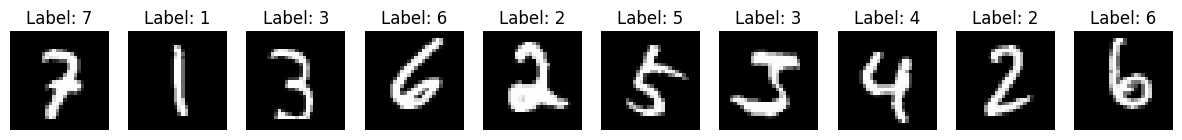

In [8]:
def convert_to_onehot(labels,num_classes):
 output = np.eye(num_classes)[np.array(labels).reshape(-1)]
 return output.reshape(list(np.shape(labels))+[num_classes])
# Displaying first 10 trainset images
num_samples = 10
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(num_samples):
 image, label = train_dataset[i]
 image = image.squeeze() # Remove the single channel dimension
 axes[i].imshow(image, cmap='gray')
 axes[i].set_title(f'Label: {label}')
 axes[i].axis('off')
plt.show()


## Model

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, use_batch_norm=False):
        super(SimpleCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block = nn.Sequential(*layers)

        fc_layers = []
        fc_layers.append(nn.Linear(32 * 7 * 7, 500))
        if use_batch_norm:
            fc_layers.append(nn.BatchNorm1d(500))
        fc_layers.append(nn.ReLU())
        fc_layers.append(nn.Linear(500, 10))

        self.fc_block = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_block(x)
        return x


## Model define

In [10]:
# Initialize model, loss function, and optimizer
net = SimpleCNN()
print(net)

SimpleCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Linear(in_features=1568, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [11]:
# Define the loss function
criterion = nn.CrossEntropyLoss().to(device)

# Function to get the Adam optimizer
def get_optimizer(parameters, lr=0.001, weight_decay=0):
    return optim.Adam(parameters, lr=lr, weight_decay=weight_decay)


## Training the CNN

In [12]:
def train_and_evaluate(use_batch_norm=False, update_best_model=True):
    # Initialize the CNN model with optional batch normalization
    net = SimpleCNN(use_batch_norm=use_batch_norm).to(device)
    
    # Use Adam optimizer for training the model
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    # Number of epochs for training
    num_epochs = 10
    # Lists to store losses and accuracies for plotting
    train_losses, val_losses, accuracies = [], [], []
    
    # Record the start time for training
    start_time = time.time()

    # Loop over epochs
    for epoch in range(num_epochs):
        train_loss = 0.0
        correct_train = 0  # Variable to track correct predictions during training
        total_train = 0  # Variable to track total samples during training
        
        # Training loop over the batches
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients before the backward pass
            optimizer.zero_grad()
            
            # Forward pass: compute model output
            outputs = net(inputs)
            
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Backward pass: compute gradients
            loss.backward()
            
            # Update model parameters based on gradients
            optimizer.step()
            
            # Accumulate training loss
            train_loss += loss.item()
            
            # Get the predicted class with the highest score
            _, predicted = outputs.max(1)
            
            # Calculate training accuracy
            total_train += labels.size(0)  # Total number of samples
            correct_train += predicted.eq(labels).sum().item()  # Correct predictions

        val_loss = 0.0
        correct = 0
        total = 0
        
        # Validation loop, no gradients needed
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass: compute validation outputs
                outputs = net(inputs)
                
                # Accumulate validation loss
                val_loss += criterion(outputs, labels).item()
                
                # Get the predicted class with the highest score
                _, predicted = outputs.max(1)
                
                # Calculate accuracy
                total += labels.size(0)  # Total number of samples
                correct += predicted.eq(labels).sum().item()  # Correct predictions

        # Average losses over the batches
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        
        # Training accuracy as a percentage
        epoch_train_accuracy = 100. * correct_train / total_train
        # Validation accuracy as a percentage
        epoch_val_accuracy = 100. * correct / total
        
        # Print the metrics for the current epoch
        print(f'Epoch: {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, '
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%')
        
        # Append losses and accuracy for plotting later
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        accuracies.append(epoch_val_accuracy)

    # Calculate the total training time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training using Adam with BatchNorm={use_batch_norm} took {elapsed_time:.2f} seconds.")

    # Plot the training and validation losses
    plt.figure(figsize=(12, 4))
    
    # Plot Train and Validation Losses
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Adam - Train and Validation Losses')

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Adam - Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

    # Testing loop: gather predictions and ground truth labels
    test_preds, test_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass: compute test outputs
            outputs = net(inputs)
            
            # Get the predicted class
            _, predicted = outputs.max(1)
            
            # Collect ground truth and predictions for evaluation
            test_true.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())

    # Calculate test accuracy
    acc = 100. * sum(np.array(test_true) == np.array(test_preds)) / len(test_true)

    # Update the best model if current accuracy is higher than the previous best
    global best_accuracy, best_optimizer, best_model
    if update_best_model and acc > best_accuracy:
        best_accuracy = acc
        best_optimizer = 'Adam'  # Always Adam in this case
        best_model = net

    # Return test accuracy, classification report, confusion matrix, and the model
    return acc, classification_report(test_true, test_preds), confusion_matrix(test_true, test_preds), net


## Plotting random images from the test set

In [13]:
def plot_predictions(model, loader, num_samples=12):
    # Initialize empty lists to hold all images and labels
    all_images, all_labels = [], []
    
    # Iterate through the data loader to collect images and labels
    for images, labels in loader:
        all_images.append(images)   # Append current batch of images to the list
        all_labels.append(labels)   # Append current batch of labels to the list

    # Concatenate all images and labels into single tensors
    all_images = torch.cat(all_images)  # Combine all image tensors into one
    all_labels = torch.cat(all_labels)  # Combine all label tensors into one

    # Randomly sample 'num_samples' indices from the dataset
    random_indices = random.sample(range(len(all_images)), num_samples)  # Generate random indices
    images = all_images[random_indices]  # Get the sampled images using the random indices
    labels = all_labels[random_indices]  # Get the corresponding labels

    # Pass the sampled images through the model to get predictions
    outputs = model(images.to(device))  # Move images to device (GPU or CPU) and forward through the model
    _, predictions = outputs.max(1)  # Get the index of the max log-probability (predicted class)

    # Calculate grid size for displaying images
    grid_size = int(math.ceil(math.sqrt(num_samples)))  # Determine the number of rows/columns for grid display
    plt.figure(figsize=(15, 15))  # Set the figure size for plotting

    # Loop through the sampled images, labels, and predictions
    for i, (img, label, pred) in enumerate(zip(images, labels, predictions)):
        plt.subplot(grid_size, grid_size, i + 1)  # Create a subplot for each image
        plt.imshow(img[0].numpy(), cmap='gray')  # Display the image in grayscale (assuming it's a single-channel image)
        plt.title(f"True: {label.item()}, Pred: {pred.item()}", fontsize=10)  # Set title showing true and predicted labels
        plt.axis('off')  # Turn off the axis for a cleaner look

    plt.tight_layout()  # Adjust the layout to prevent overlap between subplots
    plt.show()  # Display the plotted images


## Counting number of neurons and parameters

In [14]:
def count_parameters_and_neurons(model):
    # Initialize counters for total parameters and neurons
    total_params = 0
    fc_params = 0  # Parameters in fully connected layers
    conv_params = 0  # Parameters in convolutional layers
    total_neurons = 0
    fc_neurons = 0  # Neurons in fully connected layers
    conv_neurons = 0  # Neurons in convolutional layers

    # Starting dimensions for input images (assuming 28x28 images)
    h, w = 28, 28

    # Loop through each layer in the model
    for layer in model.children():
        # Check if the layer is a convolutional layer
        if isinstance(layer, nn.Conv2d):
            # Count parameters in the convolutional layer
            conv_params += sum(p.numel() for p in layer.parameters())
            
            # Calculate spatial dimensions after the convolution operation
            h = (h + 2 * layer.padding[0] - layer.kernel_size[0]) // layer.stride[0] + 1
            w = (w + 2 * layer.padding[1] - layer.kernel_size[1]) // layer.stride[1] + 1
            
            # Count neurons in the convolutional layer
            conv_neurons += layer.out_channels * h * w
        
        # Check if the layer is a max pooling layer
        elif isinstance(layer, nn.MaxPool2d):
            # Update spatial dimensions after max pooling
            h = (h - layer.kernel_size) // layer.stride + 1
            w = (w - layer.kernel_size) // layer.stride + 1
        
        # Check if the layer is a fully connected layer
        elif isinstance(layer, nn.Linear):
            # Count parameters in the fully connected layer
            fc_params += sum(p.numel() for p in layer.parameters())
            # Count neurons in the fully connected layer
            fc_neurons += layer.out_features
        
        # Check if the layer is a sequential container
        elif isinstance(layer, nn.Sequential):
            # Recursively count parameters and neurons in nested modules
            sub_results = count_parameters_and_neurons(layer)
            conv_params += sub_results['conv_parameters']
            fc_params += sub_results['fc_parameters']
            conv_neurons += sub_results['conv_neurons']
            fc_neurons += sub_results['fc_neurons']

    # Calculate total parameters and neurons
    total_params = conv_params + fc_params
    total_neurons = conv_neurons + fc_neurons

    # Print out the results
    print(f"Total parameters: {total_params}")
    print(f"Parameters in FC layers: {fc_params}")
    print(f"Parameters in Conv layers: {conv_params}")
    print(f"Total neurons: {total_neurons}")
    print(f"Neurons in FC layers: {fc_neurons}")
    print(f"Neurons in Conv layers: {conv_neurons}")

    # Return the results as a dictionary
    return {
        "total_parameters": total_params,
        "fc_parameters": fc_params,
        "conv_parameters": conv_params,
        "total_neurons": total_neurons,
        "fc_neurons": fc_neurons,
        "conv_neurons": conv_neurons
    }


## Adam optimizer

In [15]:
# Only using the Adam optimizer type
optimizer_type = "Adam"  # Set the optimizer type to Adam only
results = {}
best_accuracy = 0
best_optimizer = None
best_model = None


##  Save the information

Epoch: 1/10, Train Loss: 0.1964, Train Accuracy: 93.96%, Validation Loss: 0.0770, Validation Accuracy: 97.69%
Epoch: 2/10, Train Loss: 0.0519, Train Accuracy: 98.38%, Validation Loss: 0.0612, Validation Accuracy: 98.19%
Epoch: 3/10, Train Loss: 0.0351, Train Accuracy: 98.89%, Validation Loss: 0.0470, Validation Accuracy: 98.72%
Epoch: 4/10, Train Loss: 0.0242, Train Accuracy: 99.20%, Validation Loss: 0.0452, Validation Accuracy: 98.84%
Epoch: 5/10, Train Loss: 0.0188, Train Accuracy: 99.38%, Validation Loss: 0.0465, Validation Accuracy: 98.84%
Epoch: 6/10, Train Loss: 0.0144, Train Accuracy: 99.51%, Validation Loss: 0.0410, Validation Accuracy: 98.83%
Epoch: 7/10, Train Loss: 0.0103, Train Accuracy: 99.68%, Validation Loss: 0.0489, Validation Accuracy: 98.79%
Epoch: 8/10, Train Loss: 0.0103, Train Accuracy: 99.66%, Validation Loss: 0.0560, Validation Accuracy: 98.71%
Epoch: 9/10, Train Loss: 0.0080, Train Accuracy: 99.74%, Validation Loss: 0.0545, Validation Accuracy: 98.55%
Epoch: 10/

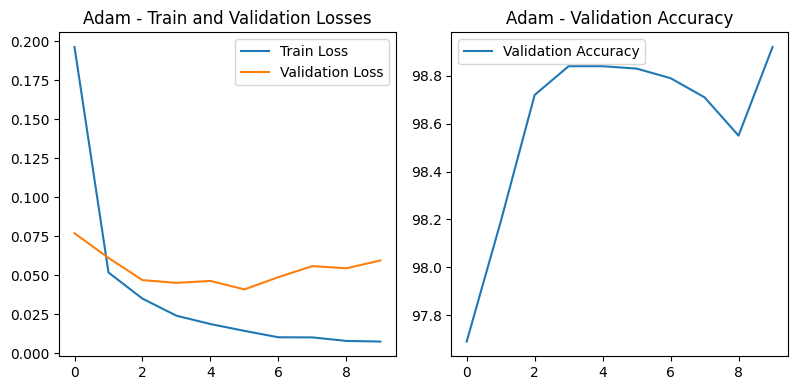

In [16]:
# Initialize results dictionary
results = {}

# Use Adam optimizer for training and evaluation
accuracy, class_report, conf_matrix, _ = train_and_evaluate()  # Remove the opt parameter
results['Adam'] = {
    "Accuracy": accuracy,
    "Classification Report": class_report,
    "Confusion Matrix": conf_matrix
}


In [17]:
def display_results(results):
    """
    Display accuracy, test loss, classification report, and a heatmap for the confusion matrix.
    This function is specifically for the Adam optimizer.
    """
    optimizer_type = 'Adam'  # Set the optimizer type to Adam

    print(f"\nResults for {optimizer_type} optimizer:")
    print(f"Accuracy: {results['Accuracy']:.2f}%")
    print(f"\nClassification Report:\n{results['Classification Report']}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(results["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {optimizer_type} optimizer")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()



Results for Adam optimizer:
Accuracy: 99.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



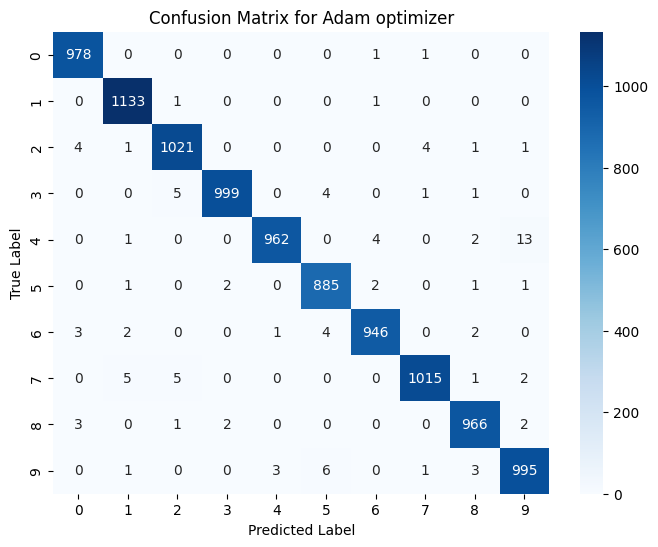

In [18]:
# Assuming `results` contains results for the Adam optimizer
display_results(results["Adam"])

## Plotting random samples

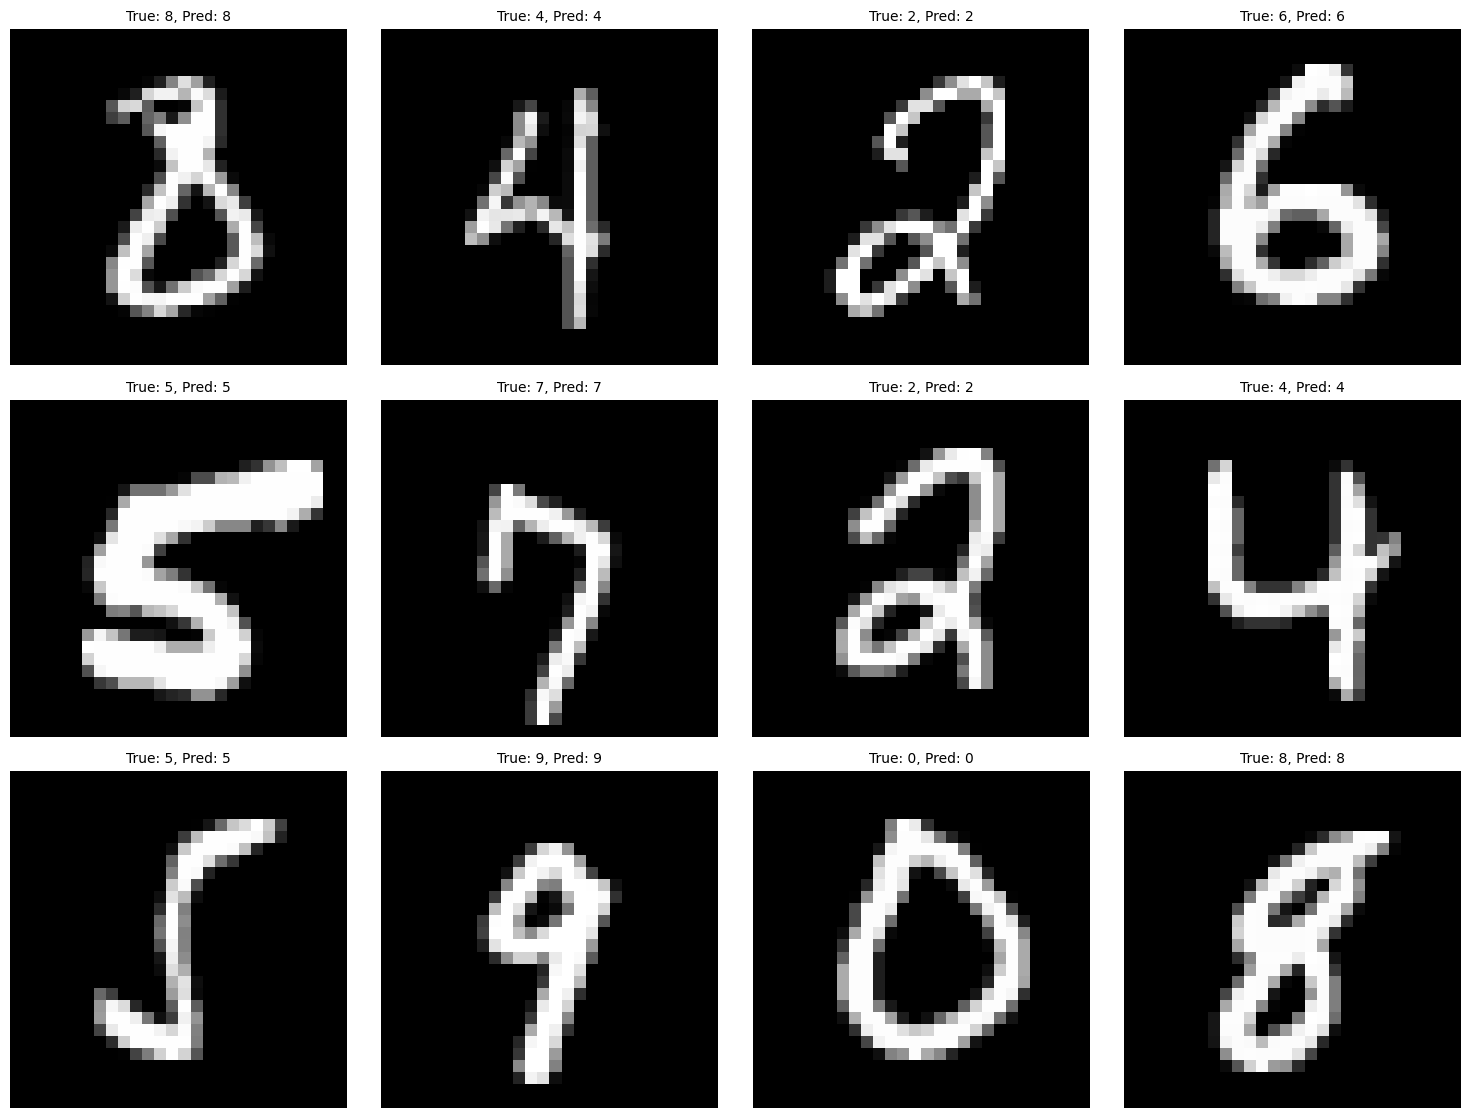

In [19]:
# Move the best model to the appropriate device (GPU or CPU)
best_model = best_model.to(device)  # Ensure best_model is defined

# Plot predictions using the test_loader
plot_predictions(best_model, test_loader)


## Layer wise Dimension

In [20]:
summary(best_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                  [-1, 500]         784,500
              ReLU-8                  [-1, 500]               0
            Linear-9                   [-1, 10]           5,010
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 3.05
Estimated Total Size (MB): 3.60
-------------------------------------------

## Number of Neurons and parameters

In [22]:
count_parameters_and_neurons(best_model)


Total parameters: 9568
Parameters in FC layers: 0
Parameters in Conv layers: 9568
Total neurons: 31360
Neurons in FC layers: 0
Neurons in Conv layers: 31360
Total parameters: 789510
Parameters in FC layers: 789510
Parameters in Conv layers: 0
Total neurons: 510
Neurons in FC layers: 510
Neurons in Conv layers: 0
Total parameters: 799078
Parameters in FC layers: 789510
Parameters in Conv layers: 9568
Total neurons: 31870
Neurons in FC layers: 510
Neurons in Conv layers: 31360


{'total_parameters': 799078,
 'fc_parameters': 789510,
 'conv_parameters': 9568,
 'total_neurons': 31870,
 'fc_neurons': 510,
 'conv_neurons': 31360}

## Training with Batch Normalisation

Epoch: 1/10, Train Loss: 0.0903, Train Accuracy: 97.25%, Validation Loss: 0.0603, Validation Accuracy: 98.07%
Epoch: 2/10, Train Loss: 0.0343, Train Accuracy: 98.84%, Validation Loss: 0.0498, Validation Accuracy: 98.43%
Epoch: 3/10, Train Loss: 0.0242, Train Accuracy: 99.18%, Validation Loss: 0.0476, Validation Accuracy: 98.62%
Epoch: 4/10, Train Loss: 0.0167, Train Accuracy: 99.44%, Validation Loss: 0.0433, Validation Accuracy: 98.79%
Epoch: 5/10, Train Loss: 0.0152, Train Accuracy: 99.48%, Validation Loss: 0.0498, Validation Accuracy: 98.69%
Epoch: 6/10, Train Loss: 0.0113, Train Accuracy: 99.62%, Validation Loss: 0.0471, Validation Accuracy: 98.79%
Epoch: 7/10, Train Loss: 0.0107, Train Accuracy: 99.62%, Validation Loss: 0.0467, Validation Accuracy: 98.74%
Epoch: 8/10, Train Loss: 0.0074, Train Accuracy: 99.72%, Validation Loss: 0.0439, Validation Accuracy: 99.00%
Epoch: 9/10, Train Loss: 0.0058, Train Accuracy: 99.79%, Validation Loss: 0.0502, Validation Accuracy: 98.75%
Epoch: 10/

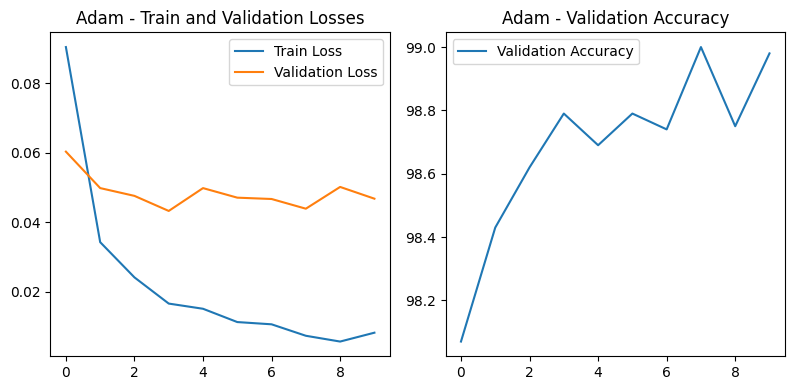

In [23]:
# Train and evaluate using Adam optimizer with batch normalization
adam_bn_acc, adam_bn_cr, adam_bn_cm, adam_bn_model = train_and_evaluate(
    use_batch_norm=True, update_best_model=False
)

# Store the results in a dictionary
adam_bn_results = {
    "Accuracy": adam_bn_acc,
    "Classification Report": adam_bn_cr,
    "Confusion Matrix": adam_bn_cm
}


In [26]:
# Summarize the Adam model with input size (1, 28, 28)
summary(adam_bn_model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           9,248
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Linear-9                  [-1, 500]         784,500
      BatchNorm1d-10                  [-1, 500]           1,000
             ReLU-11                  [-1, 500]               0
           Linear-12                   [-1, 10]           5,010
Total params: 800,206
Trainable params: 800,206
Non-trainable params: 0
-------------------------------


Results for Adam optimizer:
Accuracy: 98.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



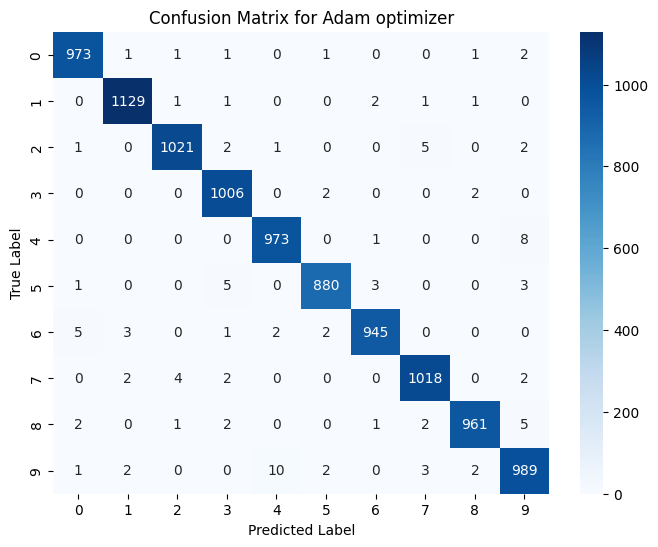

In [27]:
# Display results for the Adam optimizer
display_results(results=adam_bn_results)


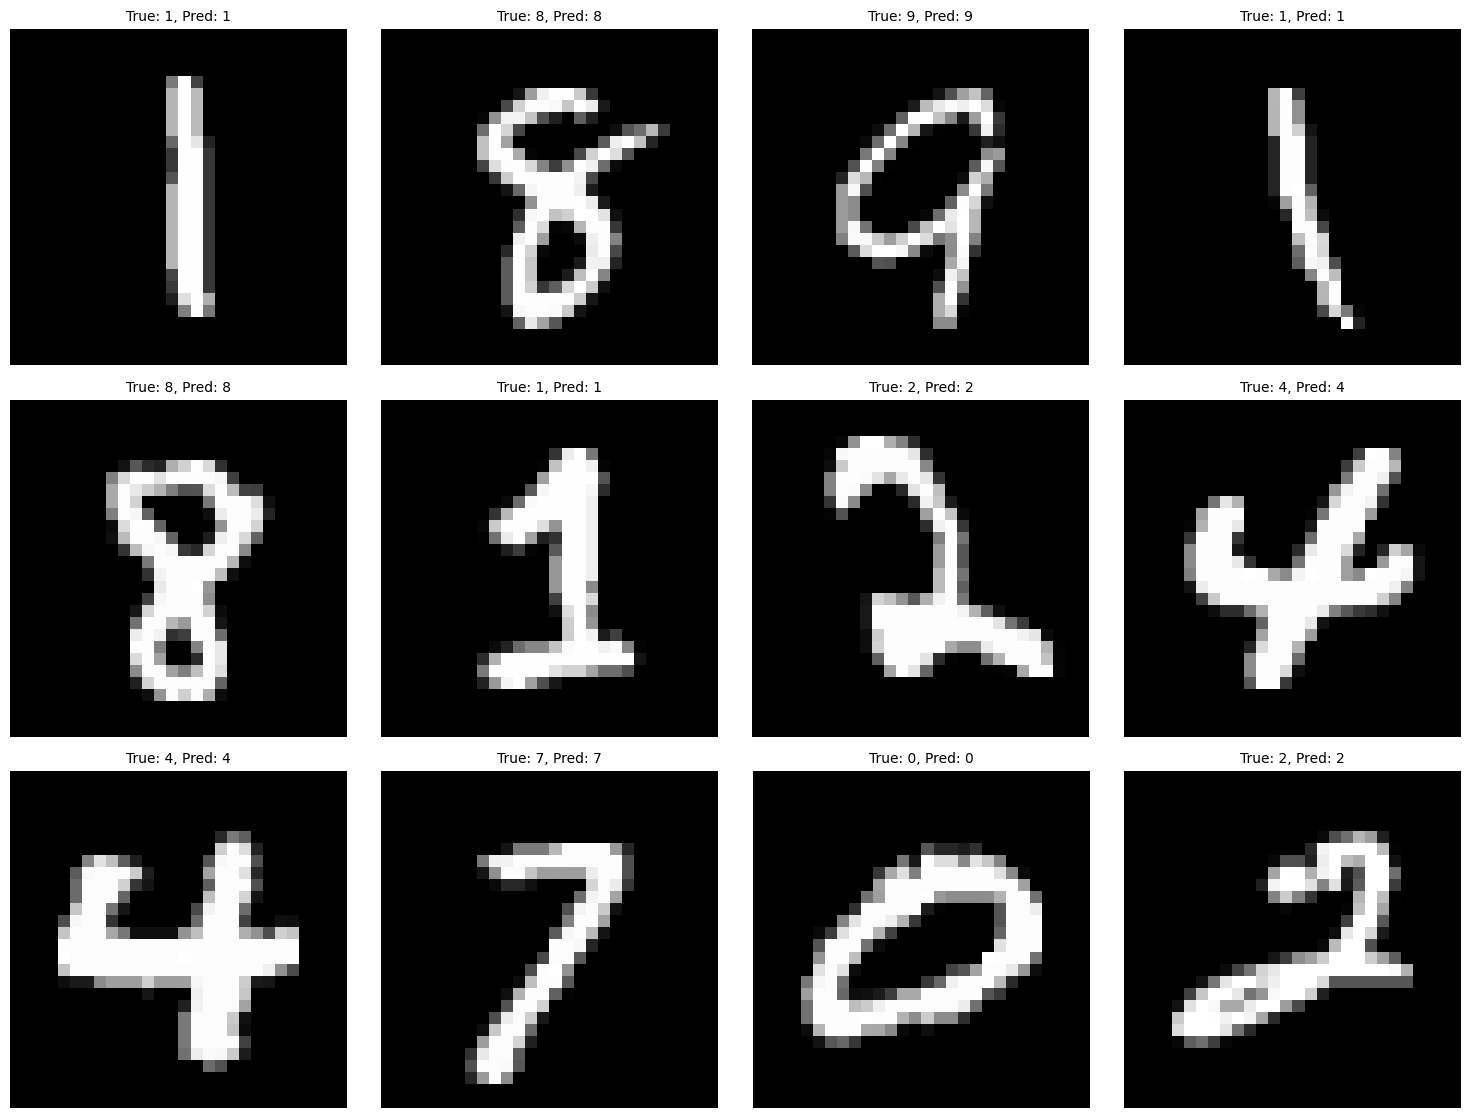

In [28]:
plot_predictions(adam_bn_model, test_loader)

## Plotting the filter

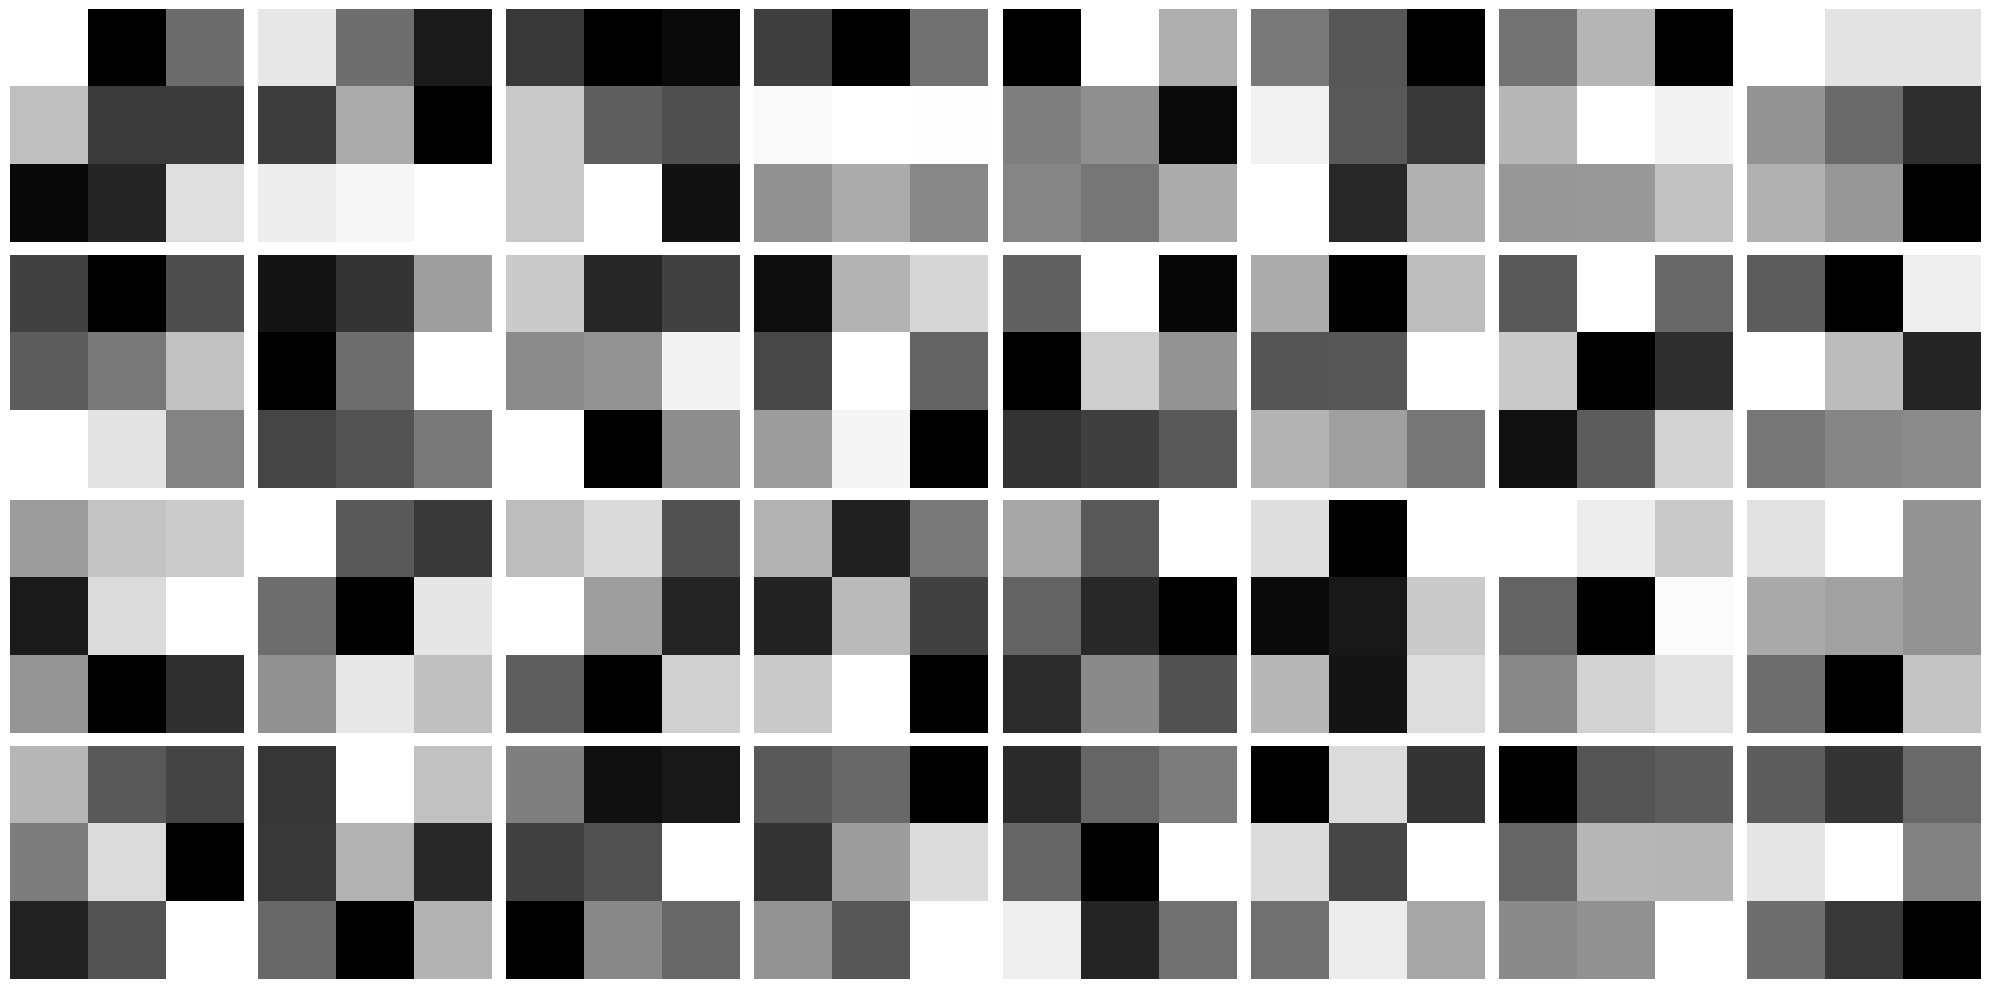

In [29]:
def plot_filters(model, layer_num, num_columns=8):
    """
    Plot the filters of a specified convolutional layer from the model.

    Parameters:
    - model: The trained model containing convolutional layers.
    - layer_num: The index of the convolutional layer to visualize.
    - num_columns: Number of columns to display in the filter grid.
    """
    # Access the specified convolutional layer by its index
    layer = dict(model.conv_block.named_children())[str(layer_num)]
    
    # Get the filters (weights) from the convolutional layer
    filters = layer.weight.data.cpu()  # Move filters to CPU if on GPU
    num_filters = filters.shape[0]  # Total number of filters in the layer
    
    # Calculate number of rows needed to display the filters
    num_rows = int(np.ceil(num_filters / num_columns))
    
    # Create a figure with subplots to display filters
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))
    
    # Loop through each filter to plot it
    for i in range(num_filters):
        row = i // num_columns  # Determine the row index
        col = i % num_columns    # Determine the column index
        ax = axes[row, col]      # Get the corresponding subplot axis
        ax.imshow(filters[i, 0, :, :], cmap="gray")  # Display the filter
        ax.axis('off')  # Hide the axis for a cleaner look
    
    # Turn off any remaining empty subplots
    for j in range(num_filters, num_rows * num_columns):
        row = j // num_columns  # Determine the row index for empty slots
        col = j % num_columns    # Determine the column index for empty slots
        axes[row, col].axis('off')  # Hide the axis for these empty slots
        
    plt.tight_layout()  # Adjust subplot parameters for a nicer layout
    plt.show()  # Show the plot

# Call the function to plot the filters of the first convolutional layer
plot_filters(adam_bn_model, 0)



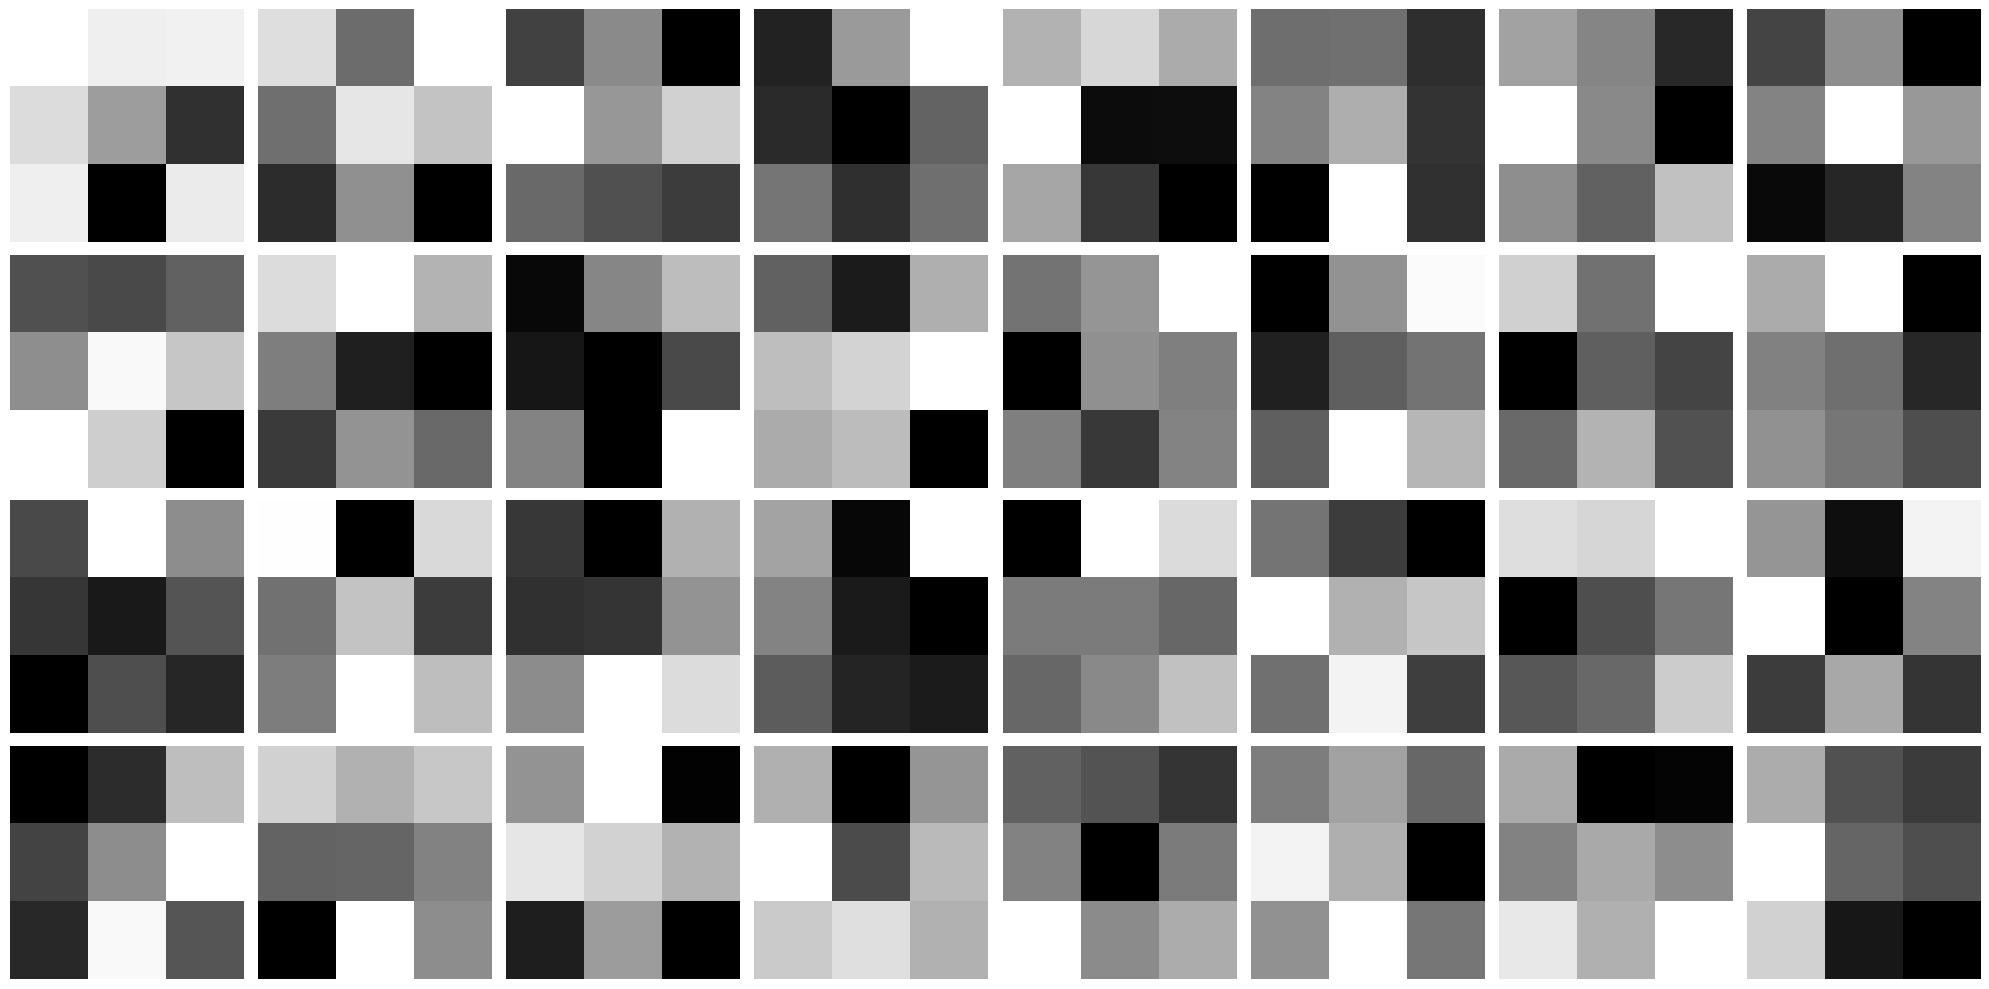

In [30]:
# Call the function to plot the filters of the 4th convolutional layer
plot_filters(adam_bn_model, 4)


## Plotting the activations

In [36]:
# Function to plot activations from a specified layer of the model
def plot_activations(model, image, layer_num, num_columns=8):
    activations = []  # List to store activations

    # Hook function to capture the output of the specified layer
    def hook(module, input, output):
        activations.append(output)

    # Get the specified layer from the model
    layer = dict(model.conv_block.named_children())[str(layer_num)]

    # Register the forward hook to capture activations
    handle = layer.register_forward_hook(hook)

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient calculation
        model(image.unsqueeze(0))  # Forward pass the image (add batch dimension)

    # Restore the model to training mode
    model.train()
    handle.remove()  # Remove the hook

    # Get the activations and process them for plotting
    act = activations[0].squeeze().cpu().detach().numpy()  # Convert to NumPy
    num_filters = act.shape[0]
    num_rows = int(np.ceil(num_filters / num_columns))  # Calculate number of rows for subplots

    # Create a grid of subplots to display the activations
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))
    for i in range(num_filters):
        row = i // num_columns
        col = i % num_columns
        ax = axes[row, col]
        ax.imshow(act[i], cmap="gray")  # Display the activation map
        ax.axis('off')  # Hide the axes

    # Hide any remaining axes in the subplot grid
    for j in range(num_filters, num_rows * num_columns):
        row = j // num_columns
        col = j % num_columns
        axes[row, col].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

    return act  # Return the activation values for further use

# Assuming you have already loaded your sample image
sample_img, _ = next(iter(test_loader))  # Get a batch of images
sample_img = sample_img.to(device)  # Move the image to the correct device (CPU or GPU)



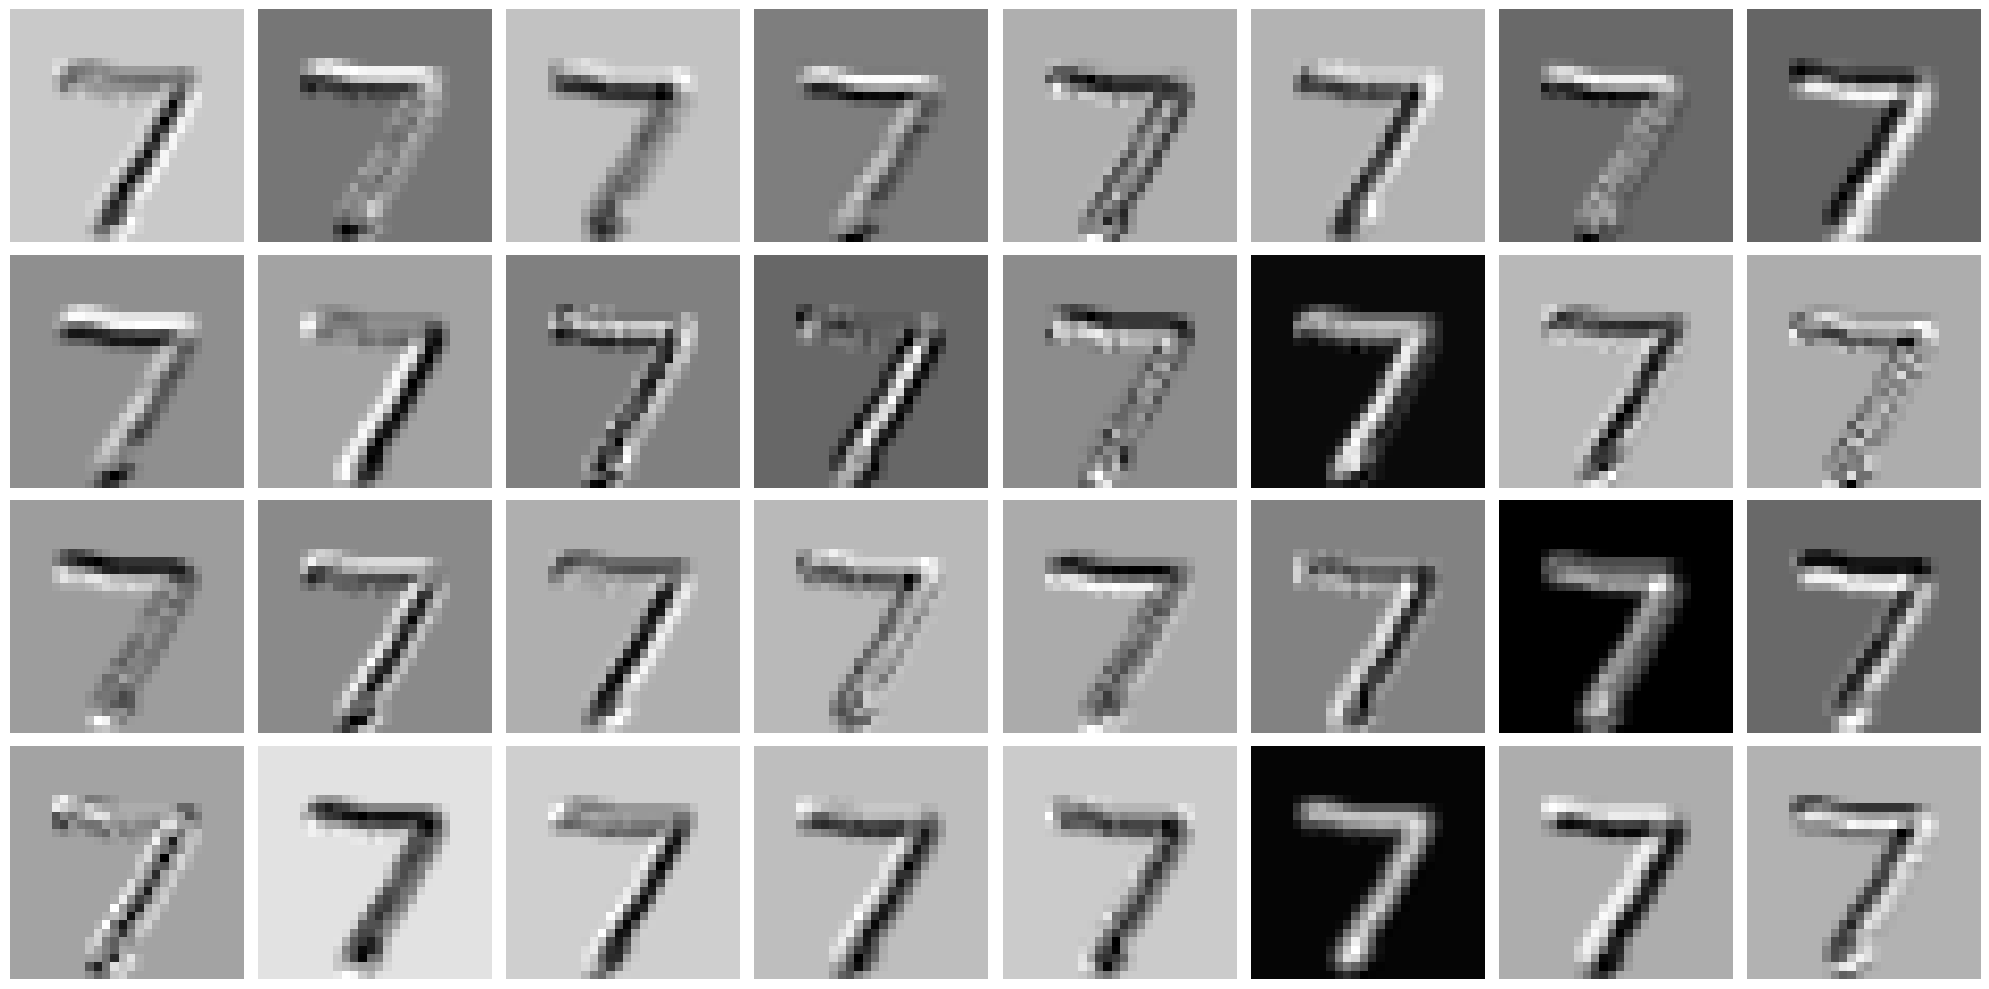

In [38]:
# Call the function to plot the activations of the first convolutional layer
activation_val_conv1 = plot_activations(
    model=adam_bn_model,         # Pass the trained model (adam_bn_model)
    image=sample_img[0],        # Use the first image from the batch (sample_img)
    layer_num=0                  # Specify the layer number for which activations are to be plotted (0 for the first layer)
)


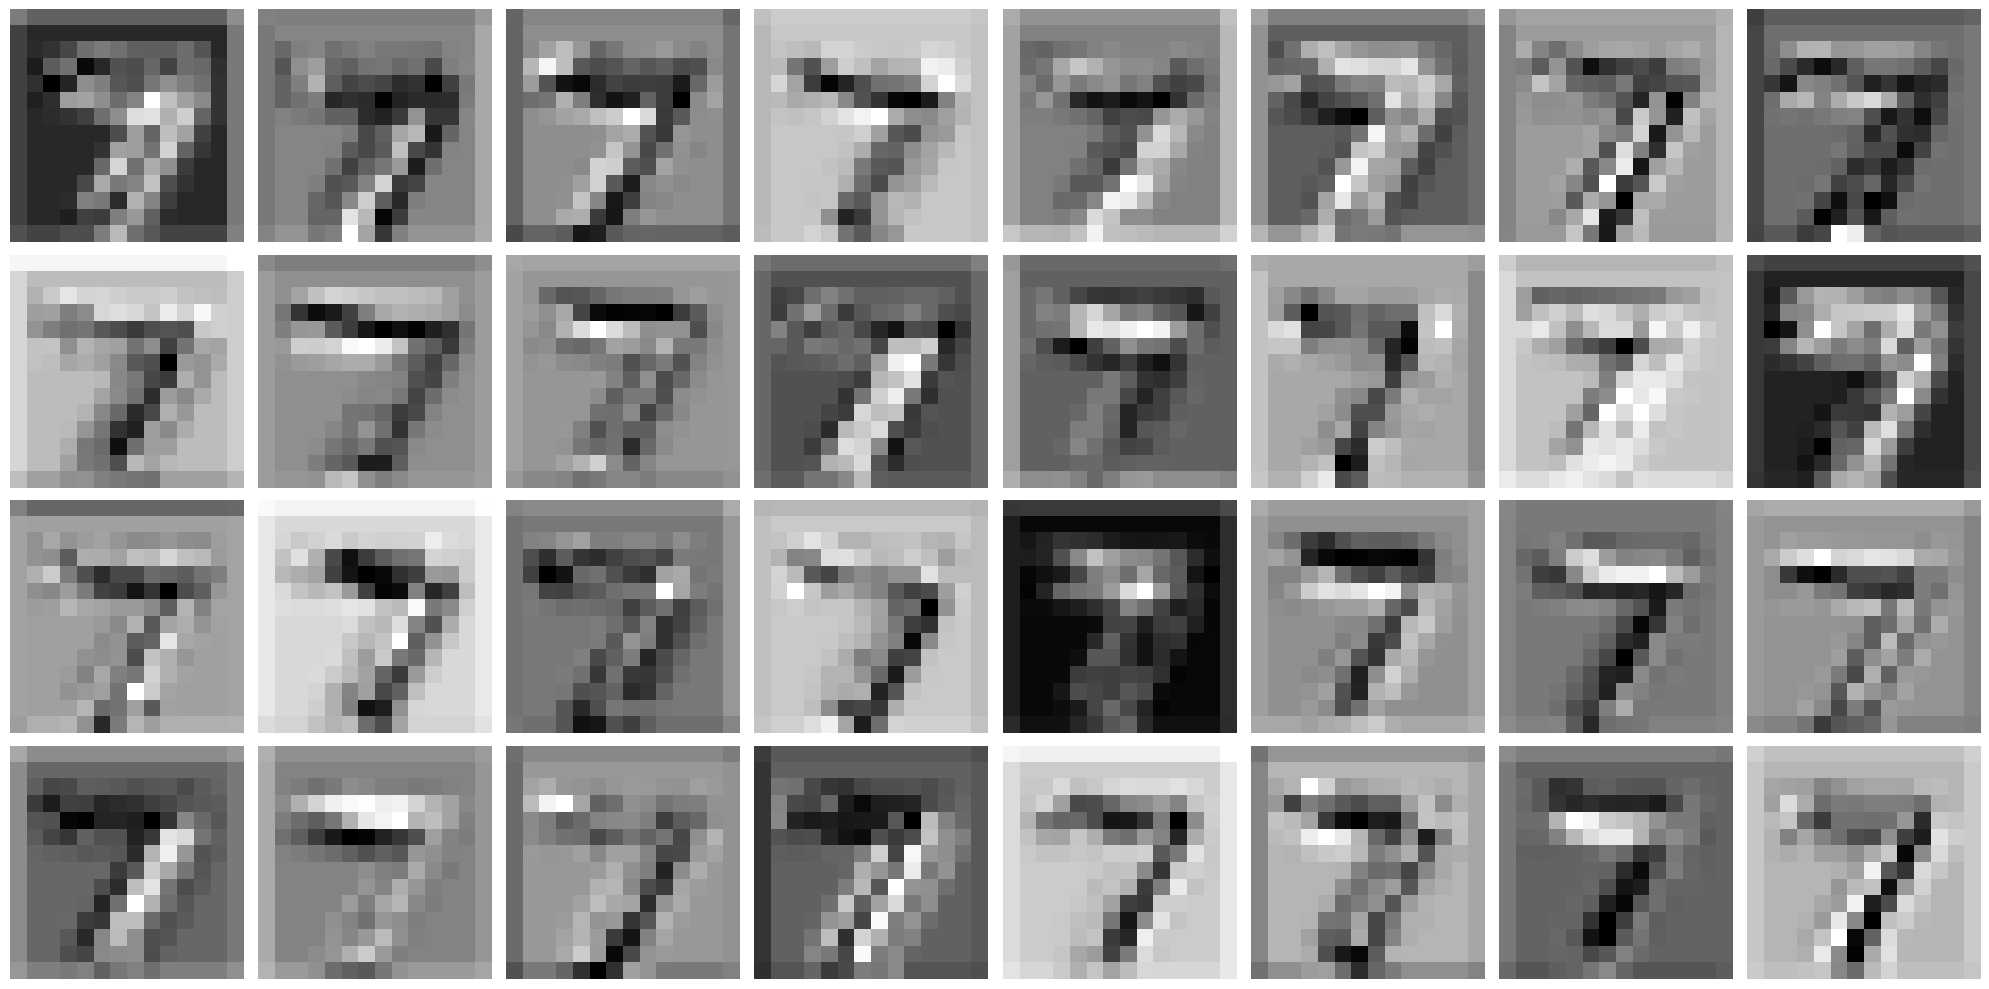

In [39]:
# Call the function to plot the activations of the 4th convolutional layer
activation_val_conv4 = plot_activations(model=adam_bn_model, 
                                         image=sample_img[0],  # Use the first image from the batch
                                         layer_num=4)  # Specify layer number 4


## Occlusion 

In [41]:
def occlusion(model, image, label, occ_size=5, occ_stride=1, occ_pixel=0.5):
    # Get the width and height of the input image
    width, height = image.shape[-2], image.shape[-1]
    
    # Calculate the dimensions of the output heatmap based on the occlusion size and stride
    output_height = int(np.ceil((height - occ_size) / occ_stride))
    output_width = int(np.ceil((width - occ_size) / occ_stride))
    
    # Initialize the heatmap with zeros
    heatmap = torch.zeros((output_height, output_width))

    # Loop over each pixel in the image
    for h in range(0, height):
        for w in range(0, width):
            # Calculate the starting and ending coordinates for the occlusion box
            h_start = h * occ_stride
            w_start = w * occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)

            # Check if the occlusion box exceeds the image boundaries
            if (w_end) >= width or (h_end) >= height:
                continue
            
            # Clone the input image to avoid modifying the original
            input_image = image.clone().detach()

            # Set the occluded region in the image to the specified pixel value
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            # Forward pass: Get model predictions for the occluded image
            output = model(input_image)
            
            # Apply softmax to convert raw output logits to probabilities
            output = nn.functional.softmax(output, dim=1)
            
            # Get the probability of the specified label for the current occlusion position
            prob = output.tolist()[0][label]
            
            # Store the probability in the heatmap
            heatmap[h, w] = prob
            
    return heatmap


## Occlusion with different Filter Size

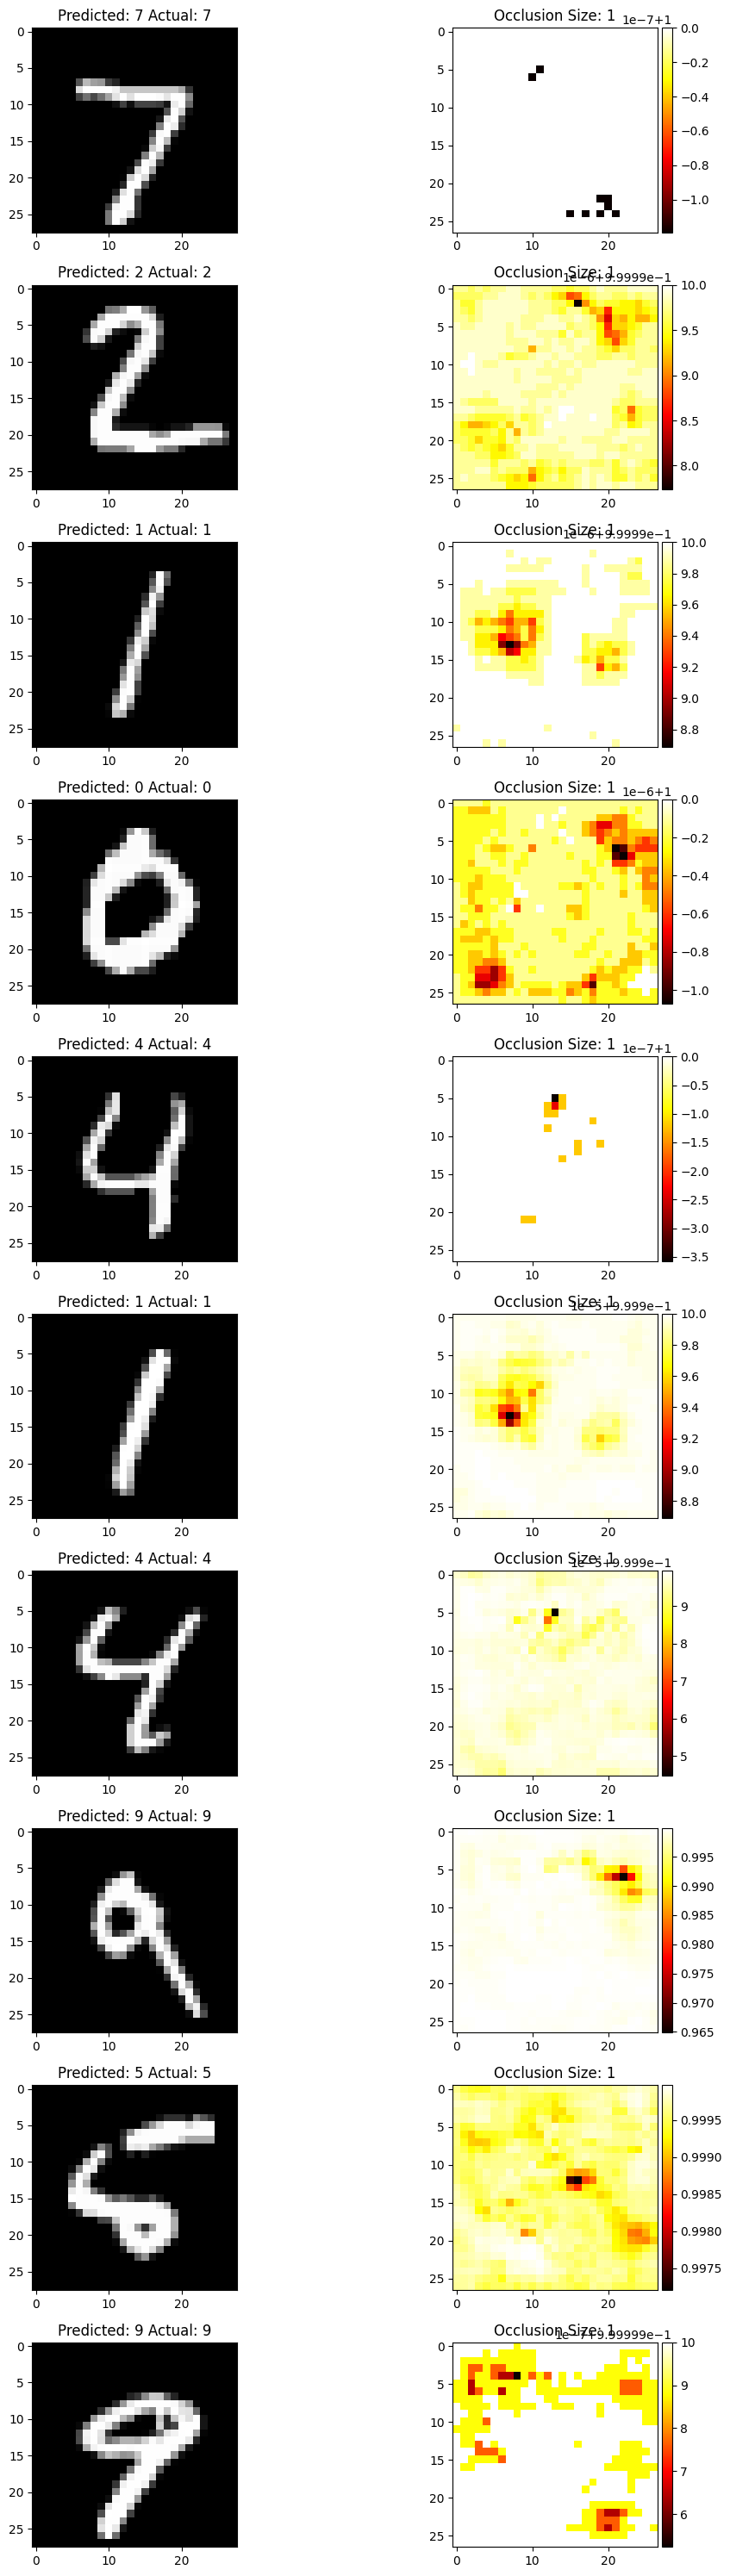

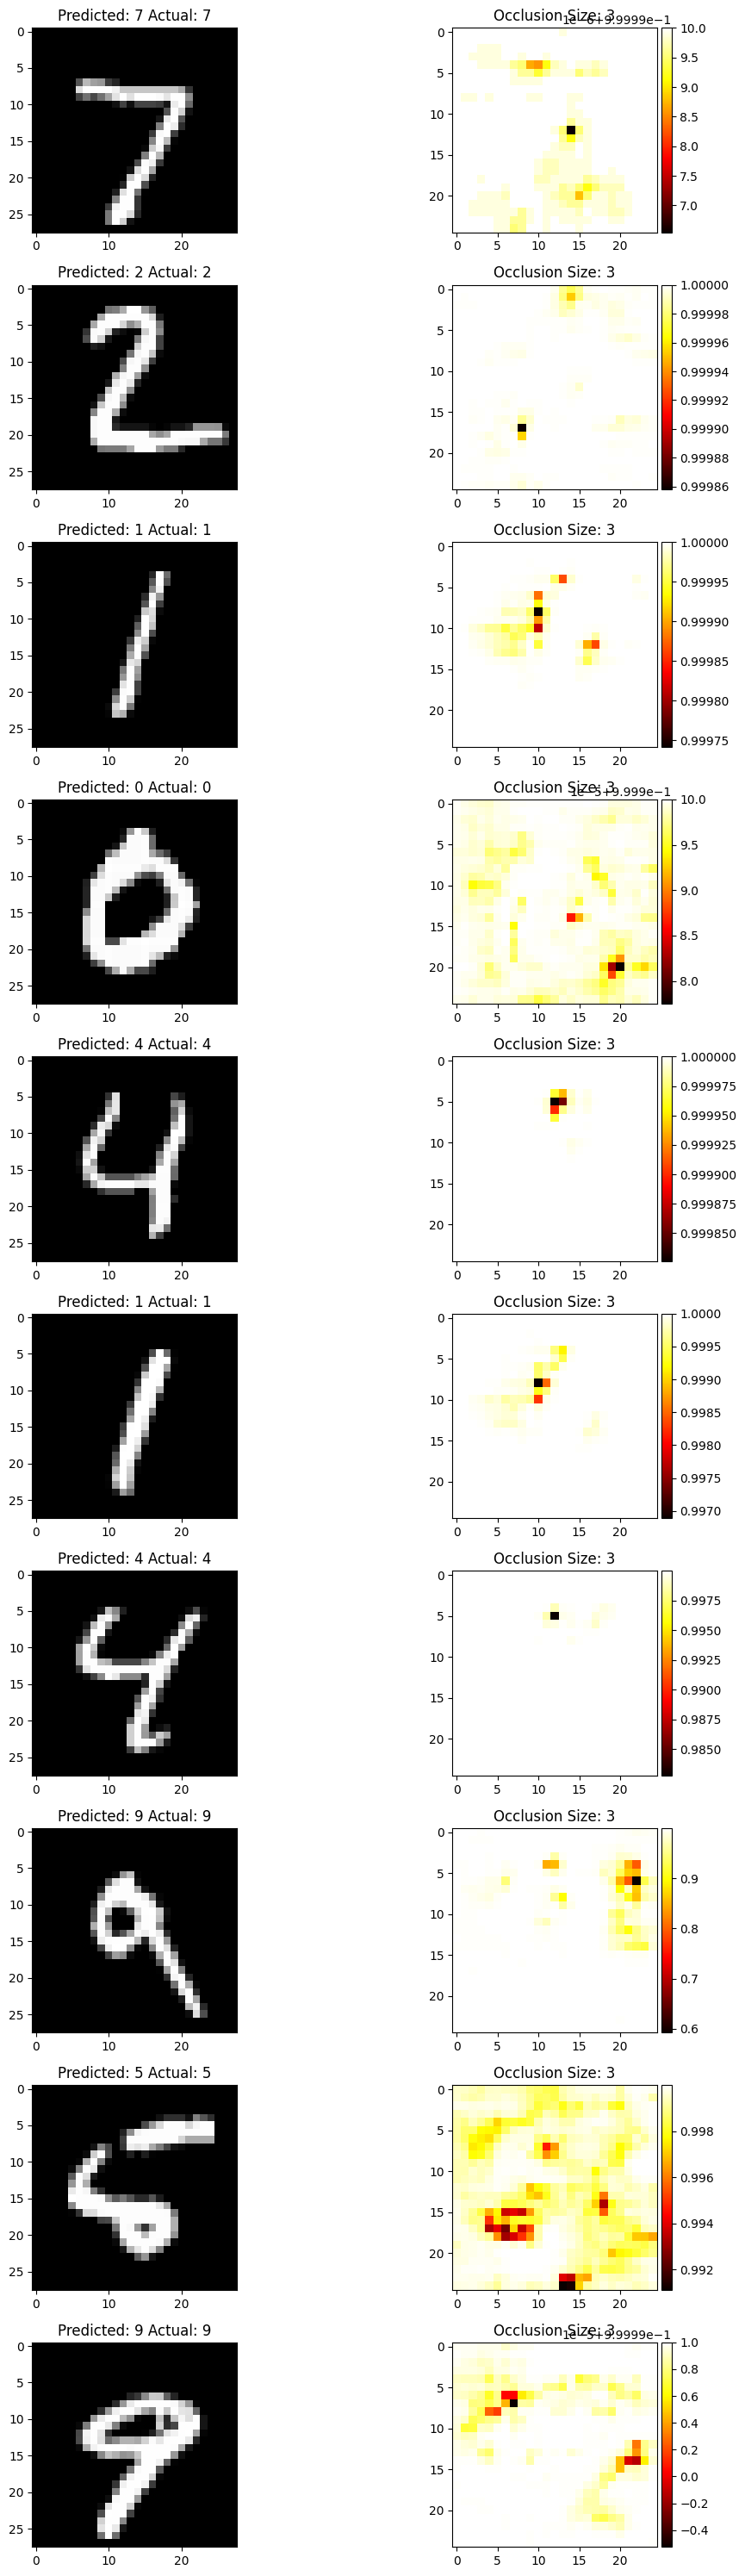

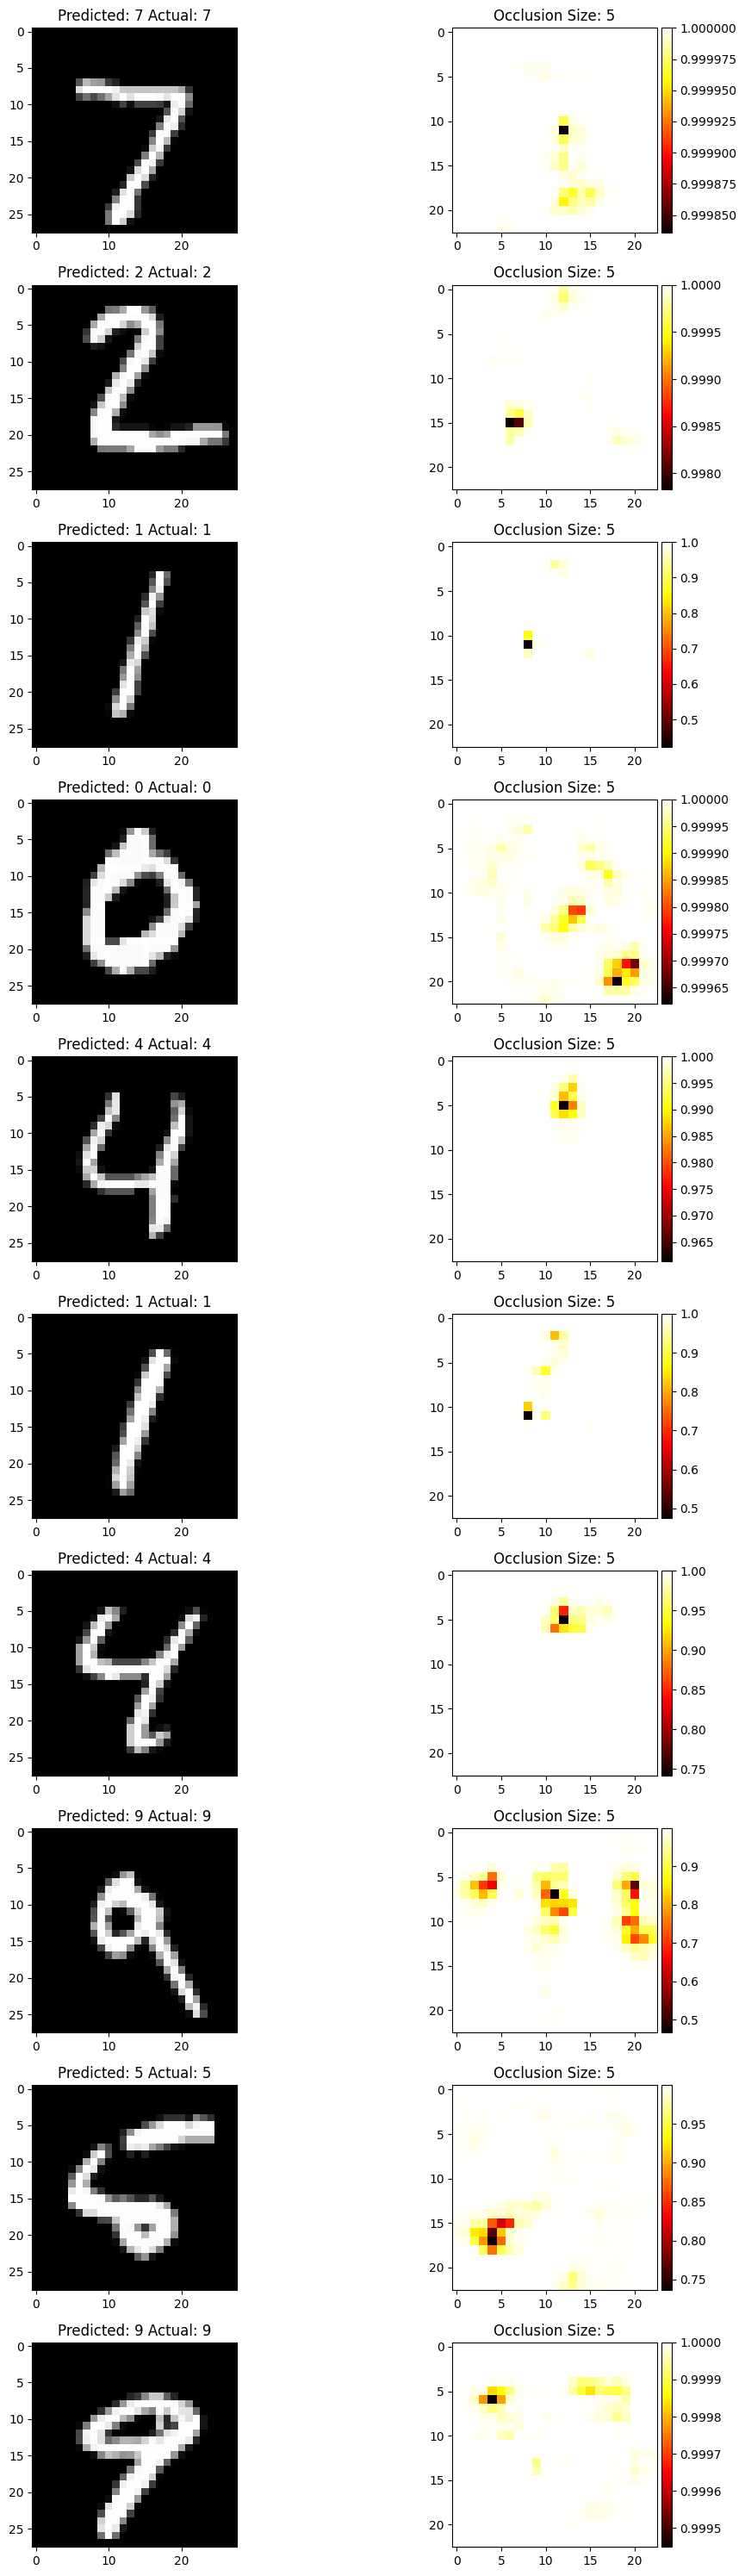

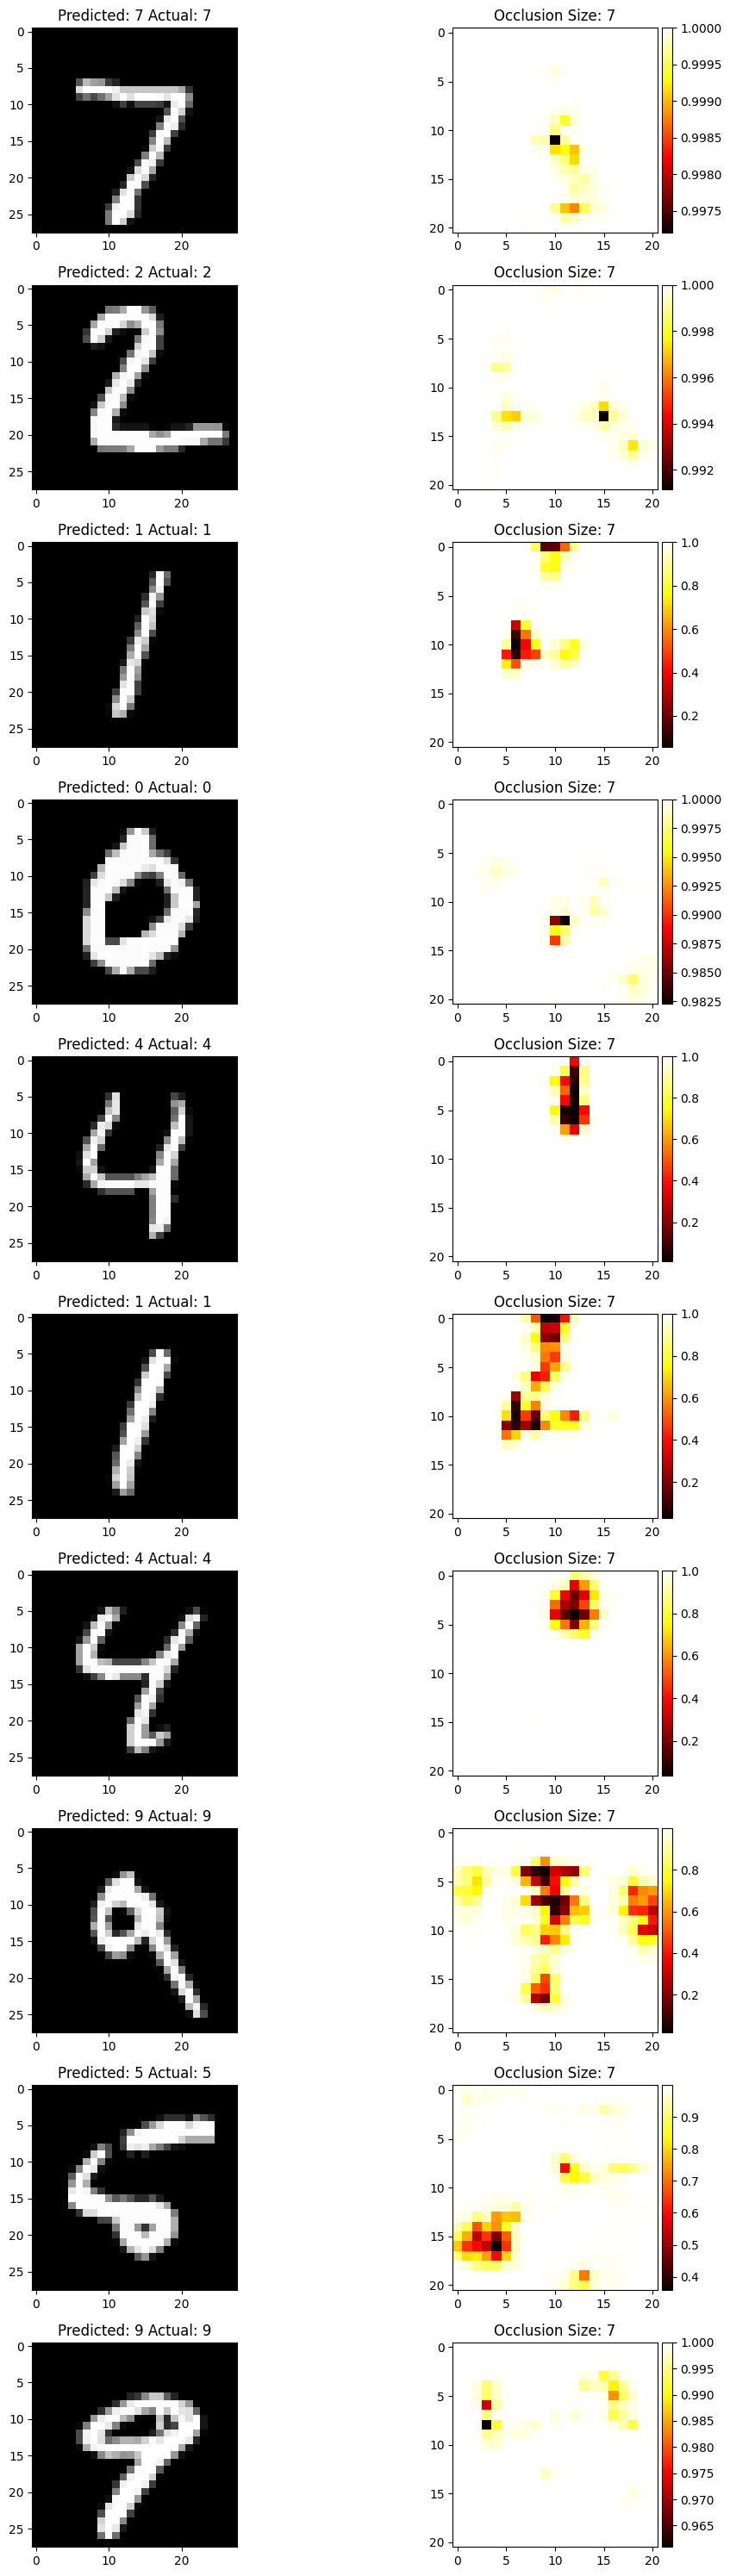

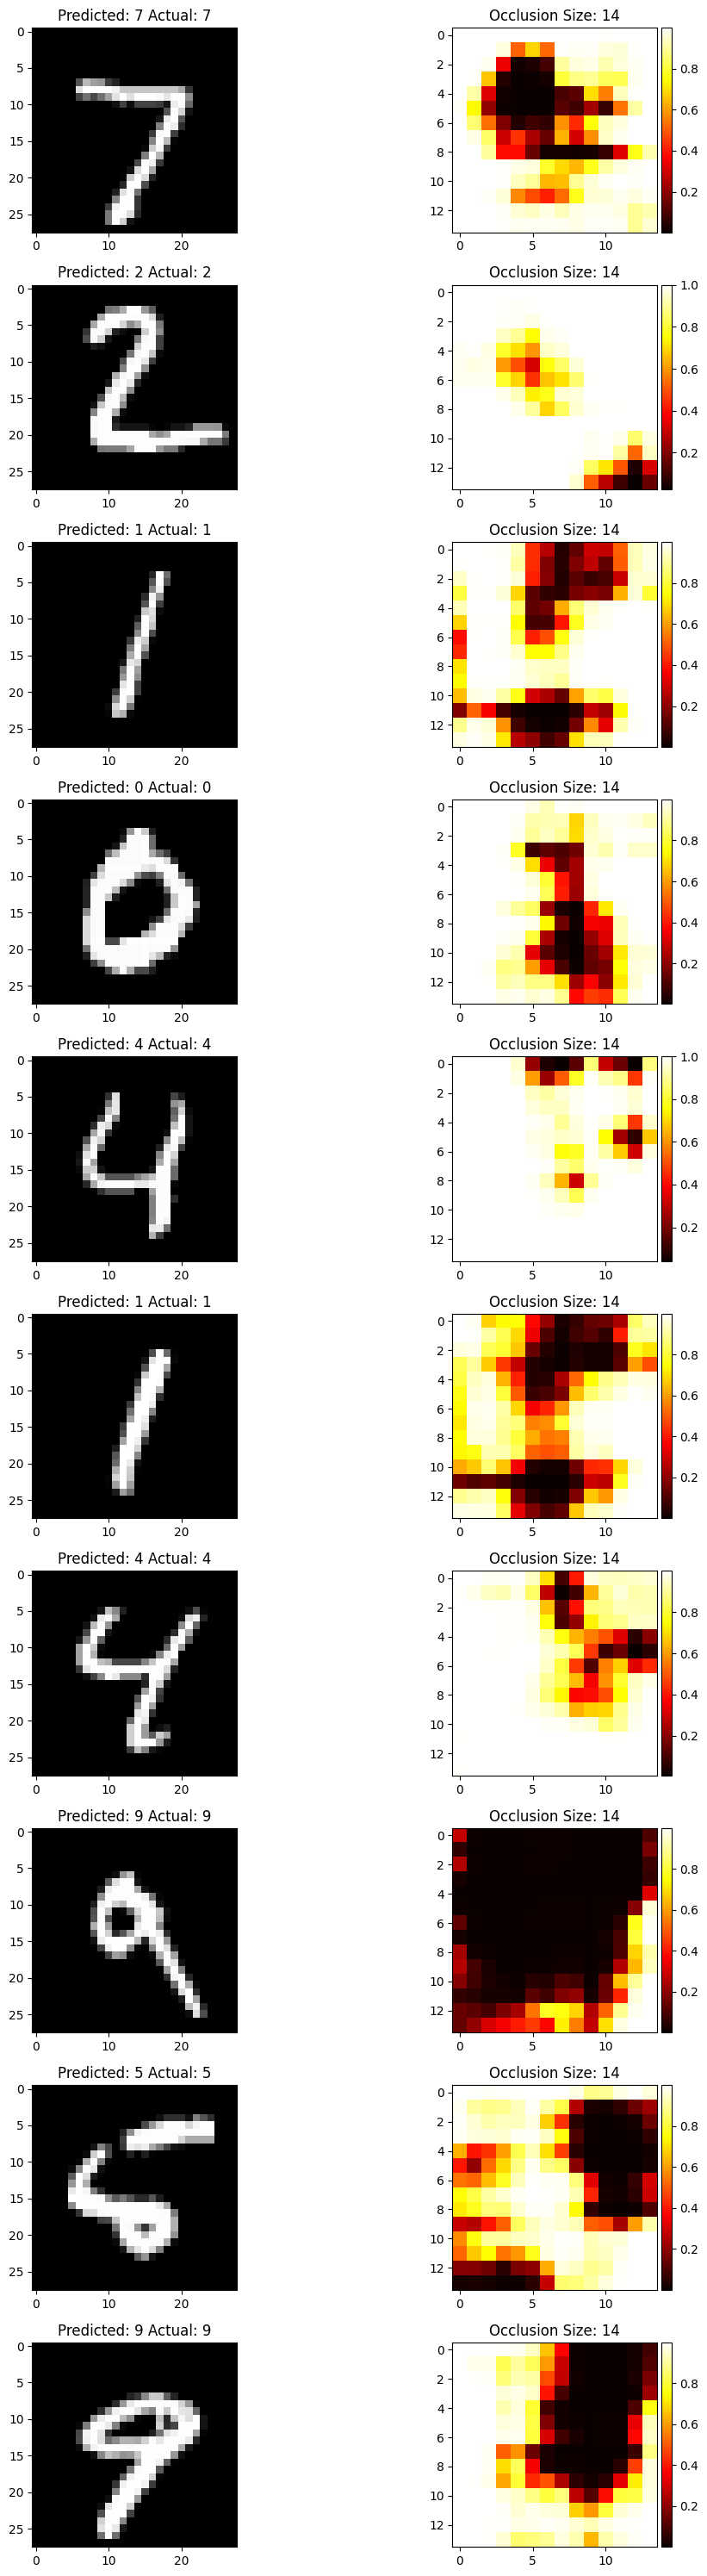

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the occlusion function
def occlusion(model, image, label, occ_size=5, occ_stride=1, occ_pixel=0.5):
    width, height = image.shape[-2], image.shape[-1]
    output_height = int(np.ceil((height - occ_size) / occ_stride))
    output_width = int(np.ceil((width - occ_size) / occ_stride))
    heatmap = torch.zeros((output_height, output_width))

    for h in range(0, height):
        for w in range(0, width):
            h_start = h * occ_stride
            w_start = w * occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            if (w_end) >= width or (h_end) >= height:
                continue

            # Create a copy of the image for occlusion
            input_image = image.clone().detach()
            input_image[:, :, h_start:h_end, w_start:w_end] = occ_pixel  # Apply occlusion

            # Forward pass to get the output
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            heatmap[h, w] = prob

    return heatmap

# Define the visualize_occlusion function
def visualize_occlusion(model, test_loader, num_images=10, occ_size=5):
    # Set the model to evaluation mode
    model.eval()
    
    # Create subplots for displaying images and heatmaps
    fig, ax = plt.subplots(num_images, 2, figsize=(12, 3 * num_images))
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        # Retrieve a batch of images and labels from the test loader
        images, labels = next(iter(test_loader))
        images = images.to(device)  # Move images to the specified device (GPU/CPU)
        labels = labels.to(device)  # Move labels to the specified device

        for i in range(num_images):
            r = i  # Row index for subplot
            c = 0  # Column index for the original image

            # Select a single image and its corresponding label
            image = images[i:i+1]
            label = labels[i]

            # Get the model's predicted class for the image
            _, predicted = torch.max(model(image).data, 1)

            # Generate an occlusion heatmap for the selected image and label
            heatmap = occlusion(model, image, label.item(), occ_size=occ_size)

            # Display the original image in the first column
            ax[r, c].imshow(image.cpu().squeeze().numpy(), cmap='gray')
            ax[r, c].set_title(f'Predicted: {predicted.item()} Actual: {label.item()}')

            # Display the occlusion heatmap in the second column
            im = ax[r, c + 1].imshow(heatmap, cmap='hot', interpolation='nearest')

            # Create a divider for the color bar next to the heatmap
            divider = make_axes_locatable(ax[r, c + 1])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Add a color bar to indicate the scale of the heatmap
            plt.colorbar(im, cax=cax)
            
            # Set the title for the heatmap with the current occlusion size
            ax[r, c + 1].set_title(f'Occlusion Size: {occ_size}')

    # Adjust layout to prevent overlap and display the plots
    plt.tight_layout()
    plt.show()

# Assuming your model is defined as 'adam_bn_model'
# Move the model to the specified device (GPU or CPU)
adam_bn_model = adam_bn_model.to(device)

# Define the Adam optimizer
optimizer = optim.Adam(adam_bn_model.parameters(), lr=0.001)  # You can adjust the learning rate as needed

# List of occlusion sizes to visualize
occlusion_sizes = [1, 3, 5, 7, 14]

# Loop through different occlusion sizes to visualize occlusion heatmaps
for occ_size in occlusion_sizes:
    # Visualize occlusion with the Adam optimizer model, test loader, and current occlusion size
    visualize_occlusion(adam_bn_model, test_loader, num_images=10, occ_size=occ_size)


## Non - targeted Adversial Attacks

In [48]:
# Function to generate adversarial examples with cost tracking
def generate_adversarial_example_with_costs(model, target_class, stepsize=0.05, 
                                             max_iterations=10000, epsilon=0.3, use_epsilon=True):
    model.eval()  # Set the model to evaluation mode
    # Initialize a random input image with a normal distribution centered around 128
    X = torch.normal(128, 1, (1, 1, 28, 28)).to(device)
    X.requires_grad = True  # Enable gradient tracking for the input
    costs = []  # List to track cost values over iterations

    for iteration in range(max_iterations):
        logits = model(X)  # Forward pass to get model predictions
        cost = logits[0, target_class]  # Extract the cost for the target class
        costs.append(cost.item())  # Store the current cost value
        model.zero_grad()  # Clear gradients from the previous iteration
        cost.backward()  # Backpropagate to compute gradients
        
        # Calculate perturbation based on the gradients
        perturbation = stepsize * X.grad.data
        if use_epsilon:
            perturbation = torch.clamp(perturbation, -epsilon, epsilon)  # Clamp perturbation within epsilon bounds
        
        # Update the input image with the perturbation
        X.data = X.data + perturbation
        # Ensure the pixel values remain within the valid range
        X.data = torch.clamp(X.data, 0, 255)
        X.grad.data.zero_()  # Reset the gradients for the next iteration
    
    return X.detach(), costs  # Return the generated adversarial example and cost history

In [49]:
# Function to plot costs for the specified target class over iterations
def plot_costs_for_target_class(generated_examples, target_class):
    costs = generated_examples['cost'][target_class]  # Retrieve costs for the target class
    plt.figure(figsize=(8, 6))
    plt.plot(costs)  # Plot the cost values
    plt.xlabel('Iterations')  # X-axis label
    plt.ylabel('Cost Value')  # Y-axis label
    plt.title(f"Cost Function for Target Class {target_class} over Iterations")  # Plot title
    plt.grid(True)  # Add grid lines for better readability
    plt.show()  # Display the plot

In [50]:
# Function to display generated adversarial images
def display_adversarial_images(generated_examples):
    plt.figure(figsize=(10, 5))
    for i, img in generated_examples['gen_egs'].items():
        plt.subplot(2, 5, i + 1)  # Create a subplot for each image
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')  # Show the image
        plt.title(f"Target: {i}")  # Title indicating the target class
        plt.axis('off')  # Hide the axis for aesthetics
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the images

In [51]:
# Function to check model predictions on the generated adversarial examples
def check_network_predictions(model, generated_examples):
    for i, img in generated_examples['gen_egs'].items():
        logits = model(img)  # Get model predictions for the image
        probs = torch.nn.functional.softmax(logits, dim=1)  # Calculate probabilities
        pred_class = torch.argmax(probs, dim=1).item()  # Get the predicted class
        confidence = probs[0, pred_class].item()  # Confidence of the prediction
        print(f"Target Class: {i}, Predicted Class: {pred_class}, Confidence: {confidence:.4f}")

In [52]:
# Main process to generate and evaluate adversarial examples
generated_examples = {'gen_egs': {}, 'cost': {}}
for i in range(10):  # Loop over target classes (0-9)
    gen_eg, cost = generate_adversarial_example_with_costs(adam_bn_model, i)  # Generate adversarial example
    generated_examples['gen_egs'][i] = gen_eg  # Store the generated example
    generated_examples['cost'][i] = cost  # Store the cost values

# Check the model's predictions on the generated adversarial examples
check_network_predictions(adam_bn_model, generated_examples)


Target Class: 0, Predicted Class: 0, Confidence: 1.0000
Target Class: 1, Predicted Class: 6, Confidence: 1.0000
Target Class: 2, Predicted Class: 2, Confidence: 1.0000
Target Class: 3, Predicted Class: 3, Confidence: 1.0000
Target Class: 4, Predicted Class: 4, Confidence: 1.0000
Target Class: 5, Predicted Class: 5, Confidence: 1.0000
Target Class: 6, Predicted Class: 6, Confidence: 1.0000
Target Class: 7, Predicted Class: 7, Confidence: 1.0000
Target Class: 8, Predicted Class: 8, Confidence: 1.0000
Target Class: 9, Predicted Class: 9, Confidence: 1.0000


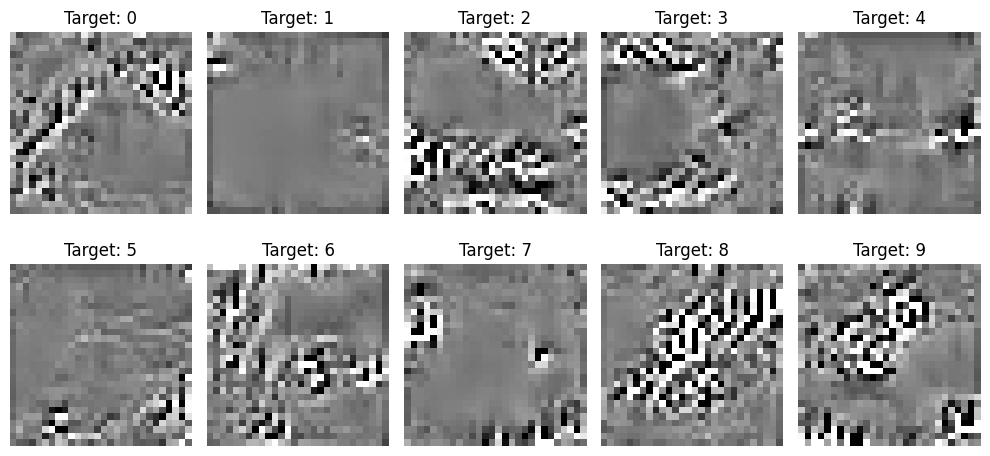

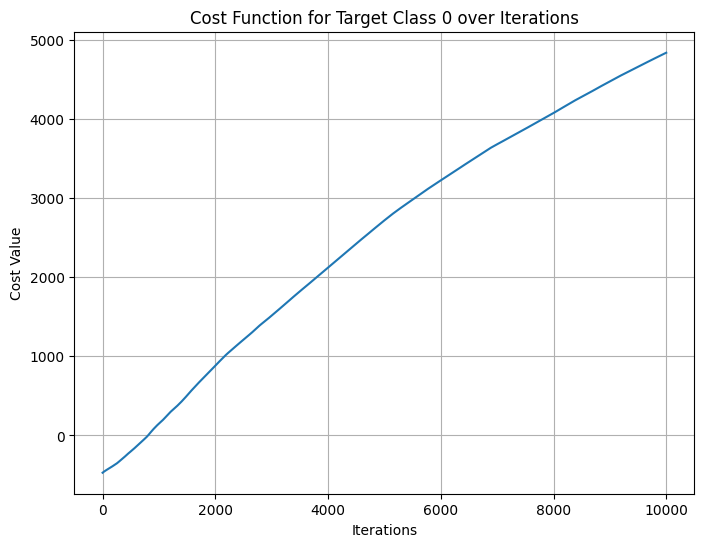

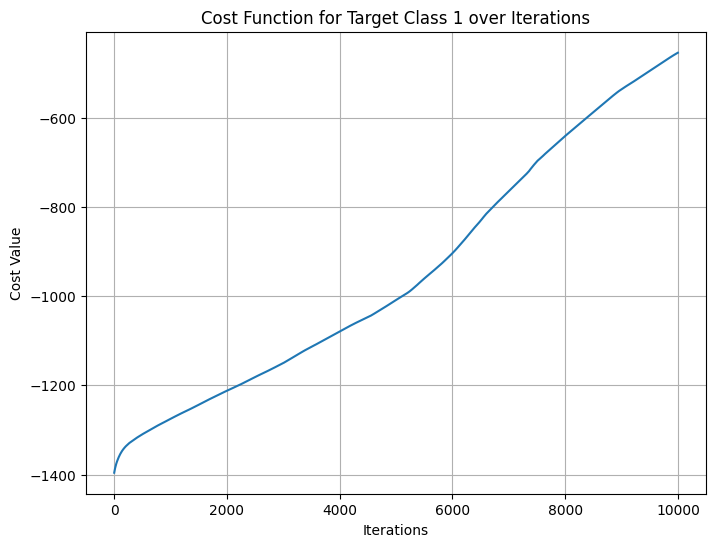

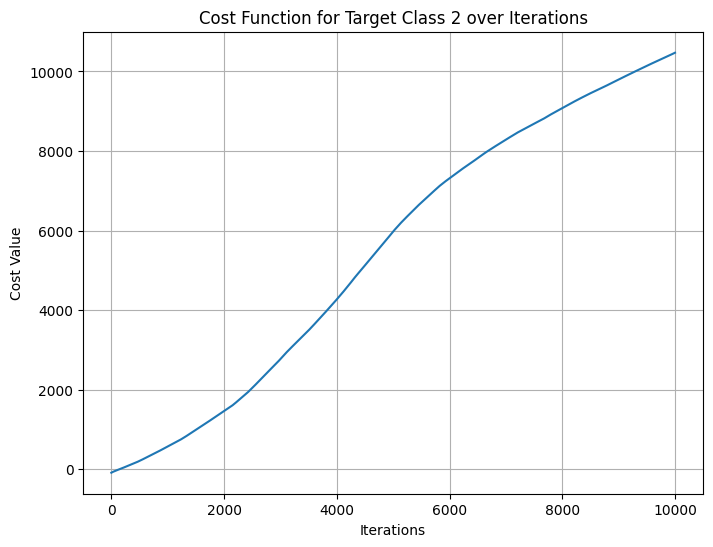

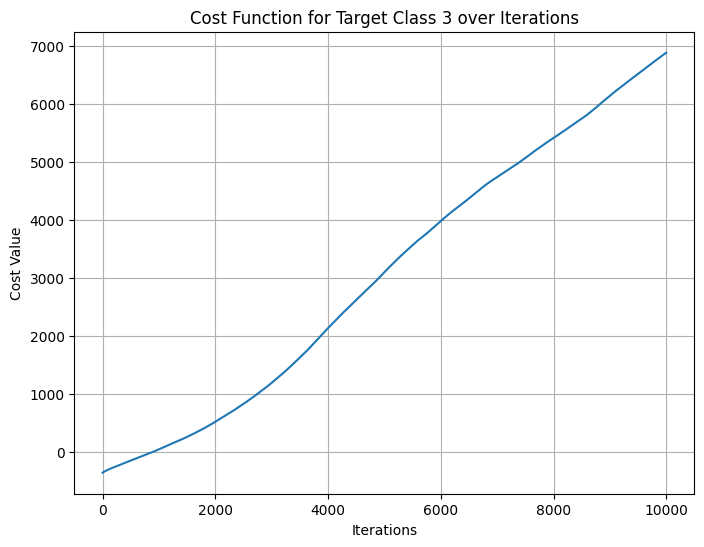

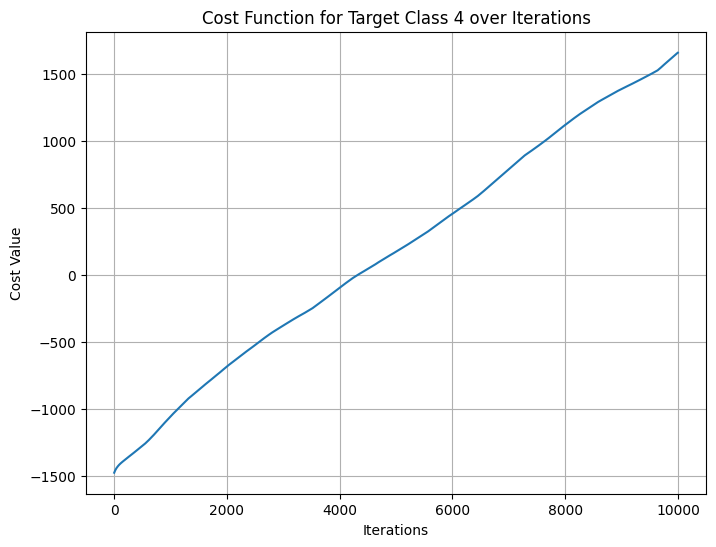

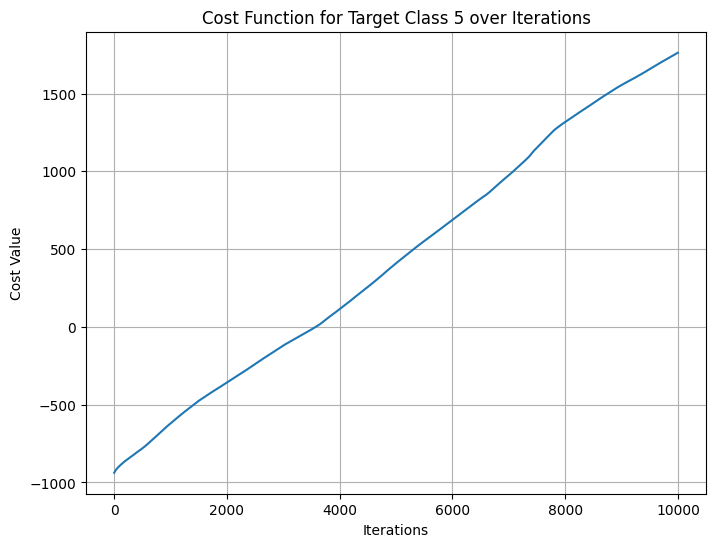

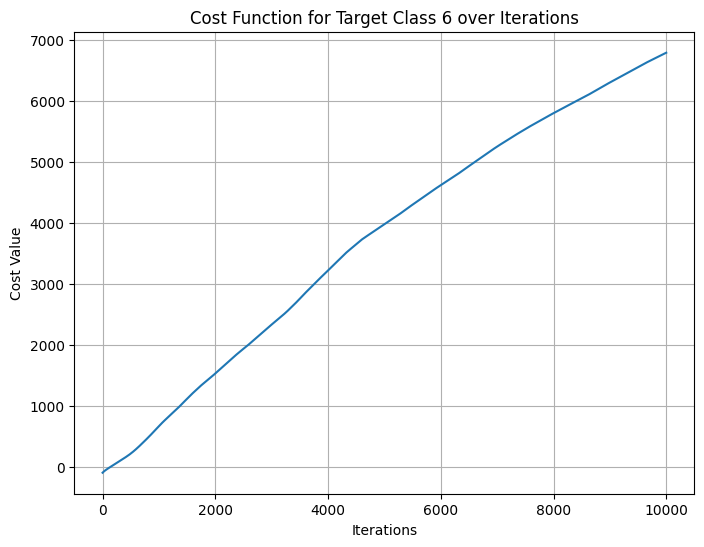

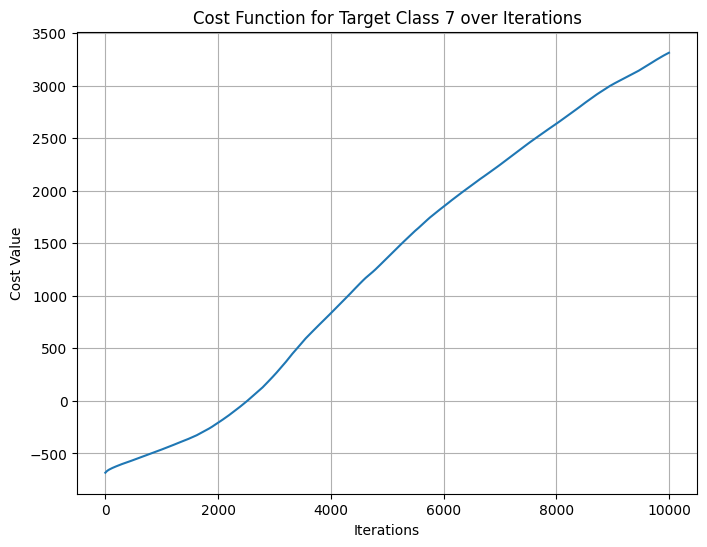

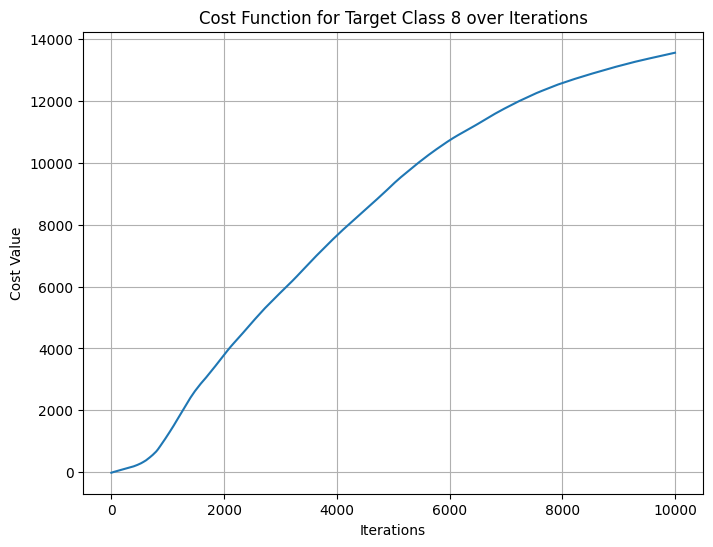

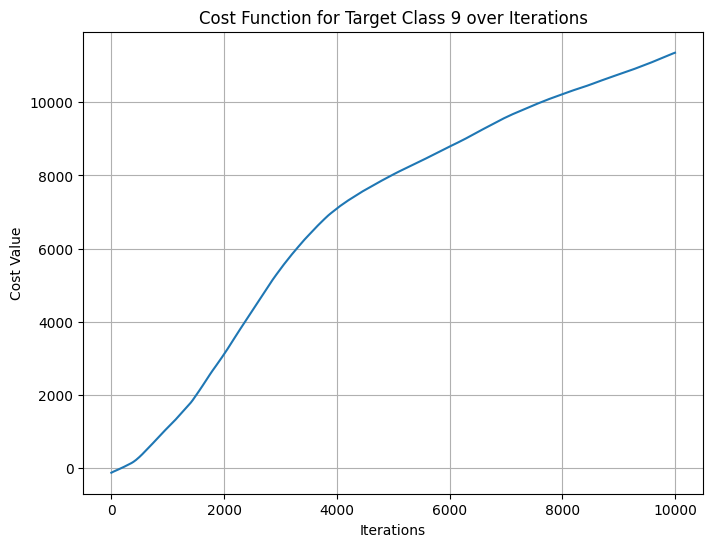

In [53]:
# Display the generated adversarial images
display_adversarial_images(generated_examples)

# Optionally plot costs for specific target classes (you can loop through target classes)
for i in range(10):
    plot_costs_for_target_class(generated_examples, i)


## Tageted Adversisal Attacks

In [55]:
# Function to generate adversarial examples targeting a specific class and minimizing the difference from a target image
def generate_target_adversarial_example(model, target_class, target_image, 
                                        stepsize=0.05, max_iterations=5000, 
                                        epsilon=0.3, use_epsilon=True, beta=0.001):
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm, etc.)
    # Initialize a random image with normal distribution centered around 128
    X = torch.normal(128, 1, (1, 1, 28, 28)).to(device)
    X.requires_grad = True  # Enable gradient tracking for the input image
    
    mse_loss = nn.MSELoss()  # Define Mean Squared Error loss function
    
    for iteration in range(max_iterations):
        logits = model(X)  # Perform forward pass through the model to get logits
        # Define cost: target class confidence minus MSE between generated and target image
        cost = logits[0, target_class] - beta * mse_loss(X, target_image)  
        model.zero_grad()  # Clear previous gradients
        cost.backward()  # Backpropagate to compute gradients
        
        # Compute perturbation based on the gradient of the input image
        perturbation = stepsize * X.grad.data
        if use_epsilon:
            perturbation = torch.clamp(perturbation, -epsilon, epsilon)  # Limit perturbation within [-epsilon, epsilon]
        
        # Update input image with the perturbation
        X.data = X.data + perturbation
        # Ensure the pixel values remain within valid range [0, 255]
        X.data = torch.clamp(X.data, 0, 255)
        X.grad.data.zero_()  # Reset gradients for the next iteration
    
    return X.detach()  # Return the adversarial image without tracking gradients

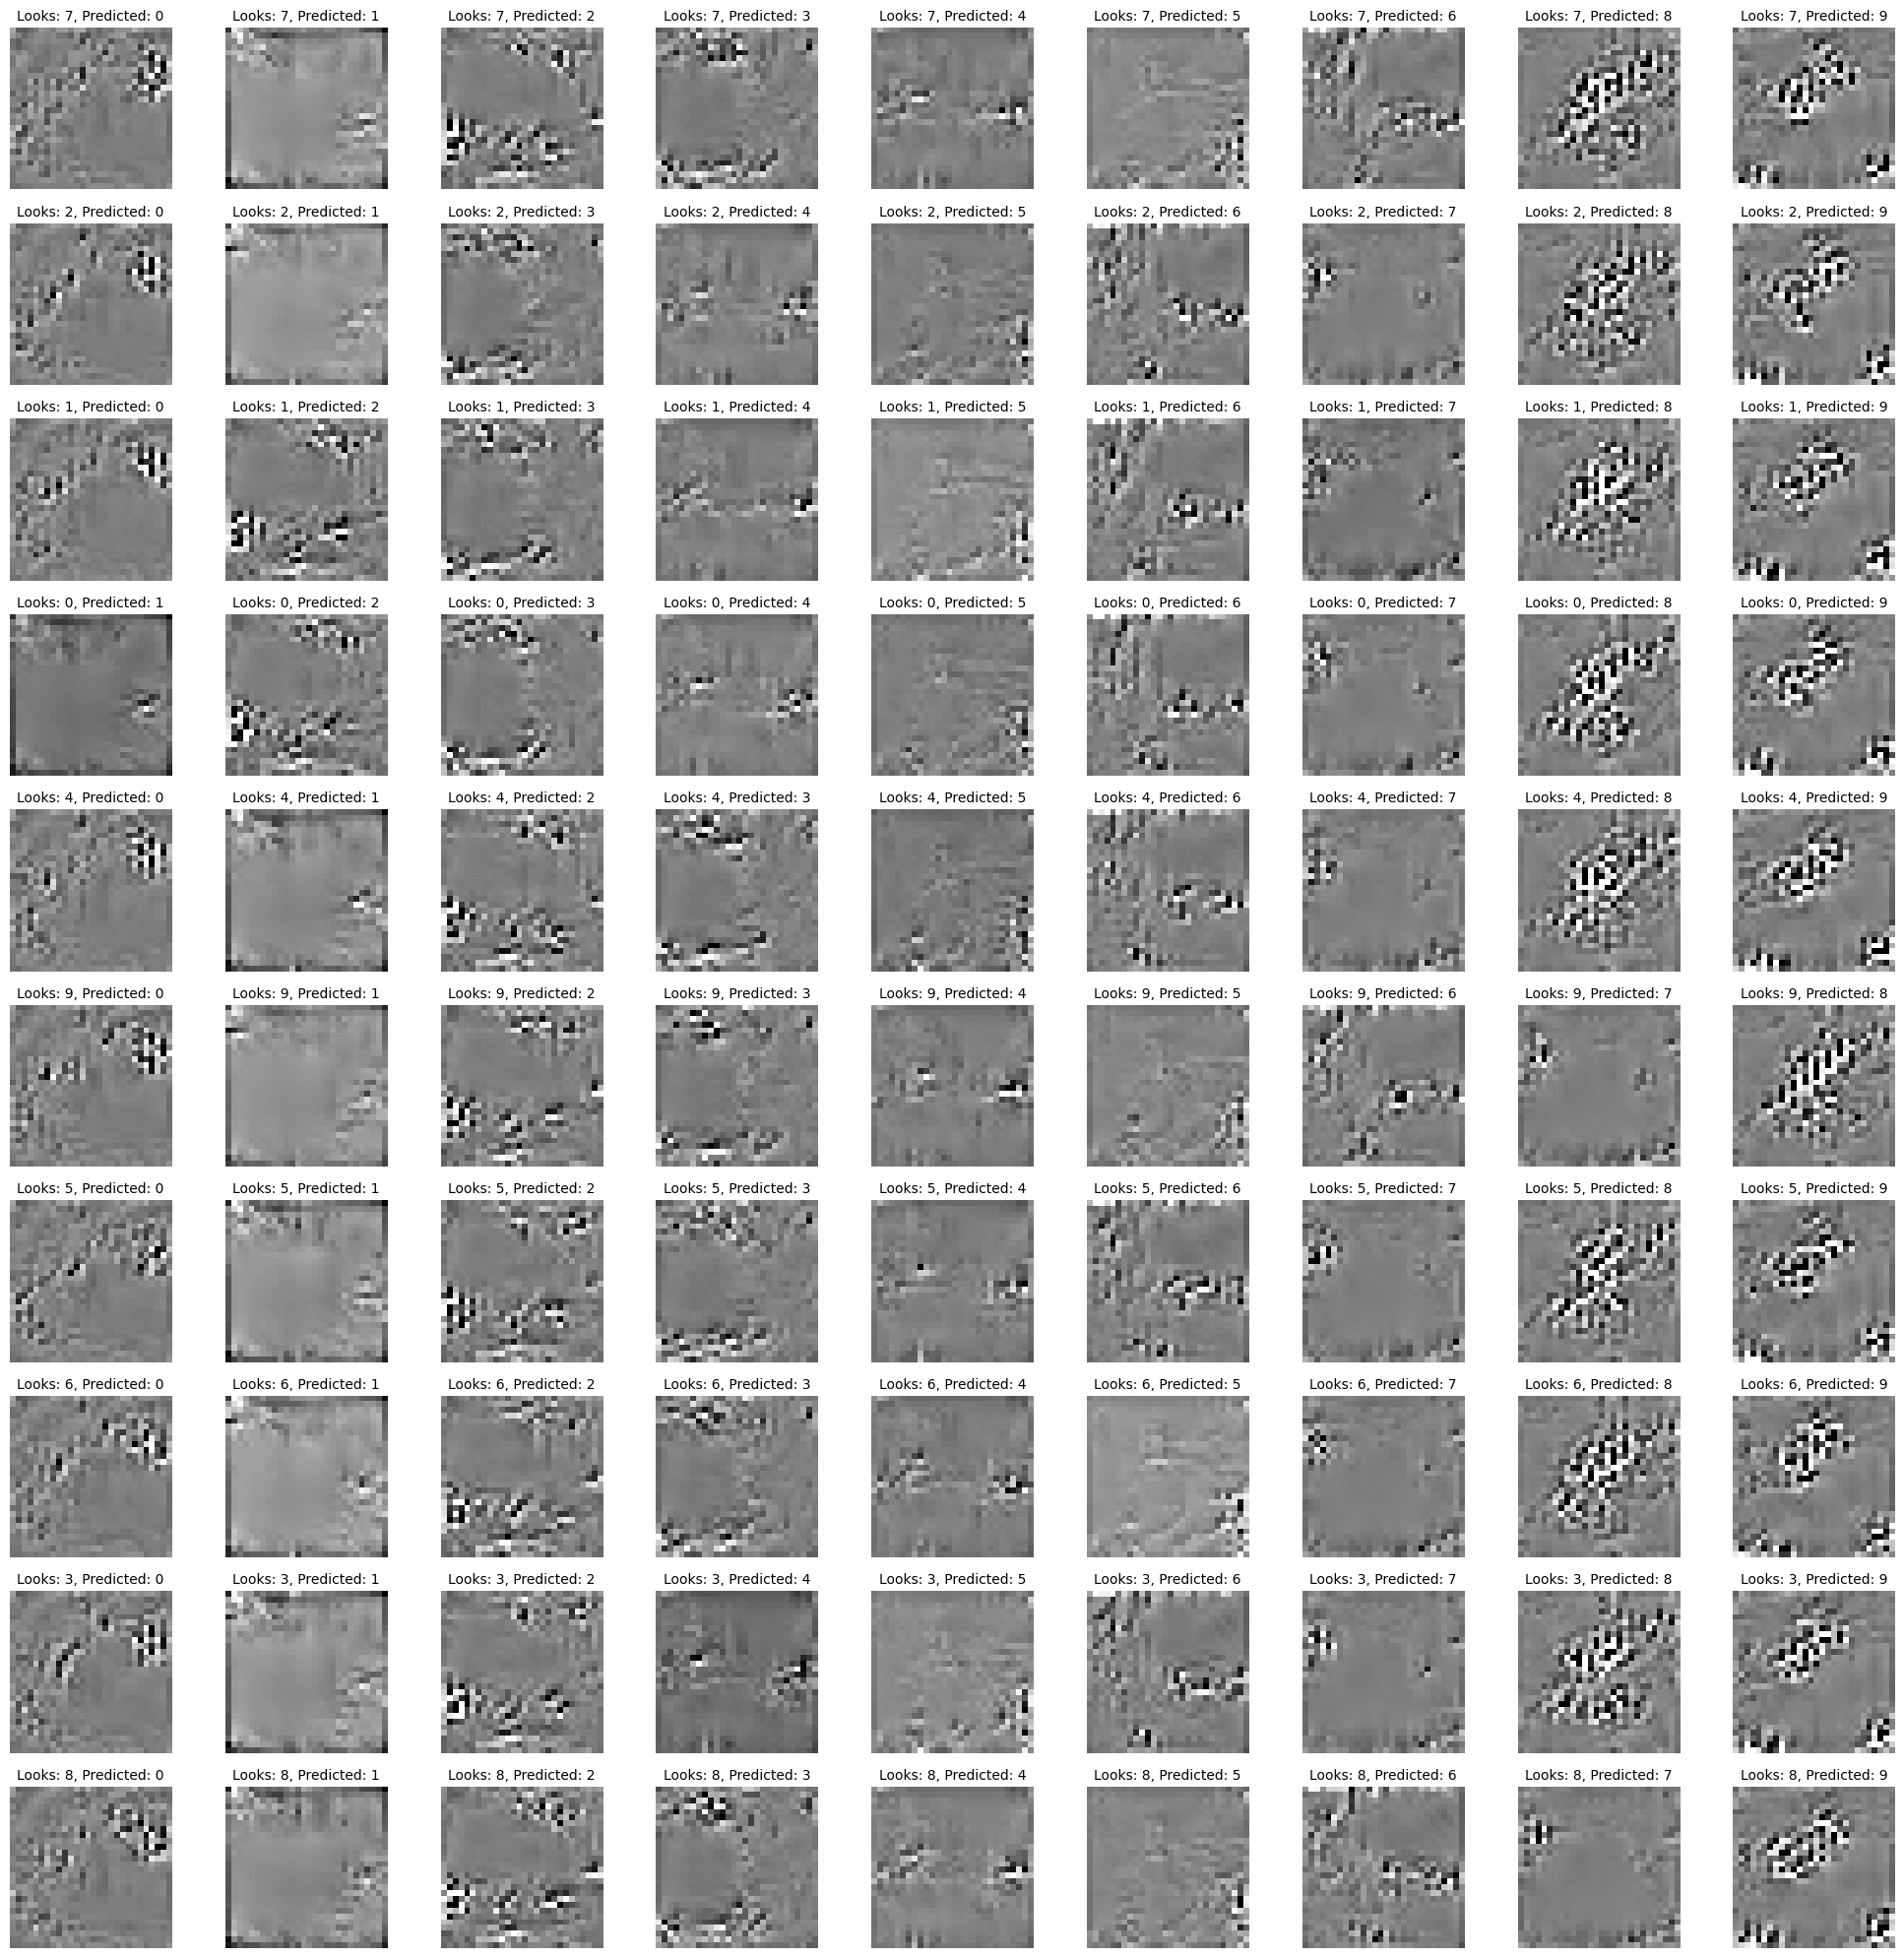

In [57]:
# Function to generate adversarial examples for each class, and display them
def classwise_adversarial_example(model, dataset, beta=0.001):
    target_images = {}  # Dictionary to hold target images for each class
    # Iterate over dataset to collect one image for each digit class (0-9)
    for _, (images, labels) in enumerate(dataset):
        for img, label in zip(images, labels):
            if label.item() not in target_images:
                target_images[label.item()] = img.to(device)  # Store the first image of each class
            if len(target_images) == 10:  # Stop when we have images for all 10 classes
                break
        if len(target_images) == 10:
            break

    adversarial_images = {}  # Dictionary to hold generated adversarial images
    # Generate adversarial examples for all combinations of true and target digit classes
    for true_digit, target_img in target_images.items():
        for target_digit in range(10):
            if true_digit != target_digit:  # Skip if true class equals target class
                adv_img = generate_target_adversarial_example(model, 
                                                              target_digit, 
                                                              target_img.unsqueeze(0), 
                                                              beta=beta)
                adversarial_images[(true_digit, target_digit)] = adv_img  # Store generated adversarial image
    
    # Display the generated adversarial images
    plt.figure(figsize=(20, 20))
    for i, ((true_digit, target_digit), img) in enumerate(adversarial_images.items()):
        plt.subplot(10, 9, i + 1)  # Create a grid for displaying images
        plt.imshow(img[0, 0].cpu().numpy(), cmap='gray')  # Show image in grayscale
        plt.title(f"Looks: {true_digit}, Predicted: {target_digit}", fontsize=10)  # Title showing true and target class
        plt.axis('off')  # Hide axes for cleaner appearance
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()  # Display the images

# Run the classwise adversarial example generation on the test dataset
classwise_adversarial_example(adam_bn_model, test_loader)
